Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = $3\cdot 10^{-2}$
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
from keras.datasets import cifar10
(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
print("Input shape:",X_train.shape)

Input shape: (50000, 32, 32, 3)


In [4]:
Xstd_train = X_train.astype(DTYPE_OP)/255
Xstd_test = X_test.astype(DTYPE_OP)/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

### Load annotations

In [5]:
scenario = 5
path = "."
state_sce = path+"/synthetic/CIFAR/state_CIFAR_s"+str(scenario)+".pickle"
#state_sce = None #random state

In [6]:
from code.generate_data import SinteticData

GenerateData = SinteticData(state=state_sce)

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario ==5 or scenario==7:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_normal.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_normal.csv')

elif scenario == 2 or scenario == 6: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_badMV.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_badMV.csv')
real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 6 or scenario ==7:
    Tmax = 2000
    T_data = 10 
elif scenario == 5:
    Tmax = 10000
    T_data = 20
    
print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3 or scenario==7: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones con este valor

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

#print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))
print("Accuracy of MV on train: ",np.mean(GenerateData.yo_label == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.85384
Shape (data,annotators):  (50000, 10000)
Classes:  10


In [30]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.1 , 0.25])

In [7]:
#save it
import pickle
new_state = GenerateData.init_state
with open('state_CIFAR_s'+str(scenario)+'.pickle', 'wb') as handle:
    pickle.dump(new_state, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Delta Convergence criteria

In [7]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [8]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_CNN(Xstd_train.shape[1:],Z_train_onehot.shape[1])
model_UB.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.rmsprop(1e-4))
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 12


In [8]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [9]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

if y_obs.shape[1] <= 3000:
    ds_labels,ds_conf = label_I.DS_labels()

In [10]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
if y_obs.shape[1] <= 3000:
    print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.85384


In [11]:
model_mvsoft = default_CNN(Xstd_train.shape[1:],mv_probas.shape[1])
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 3


In [19]:
model_mvhard = default_CNN(Xstd_train.shape[1:],mv_onehot.shape[1])
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 11


In [19]:
model_ds = default_CNN(Xstd_train.shape[1:],ds_labels.shape[1])
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 6


### Raykar Model (joint predict model)

In [12]:
from code.baseline import RaykarMC
#get raykar represenstation
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (50000, 2000, 10)


from baseline import RaykarMC

raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,iterations=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

In [21]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

logL_hists,i_r = raykarMC.multiples_run(15,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (2000, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done,  E step: done //  (in 107.07 sec)	logL: -745894.562	
Iter 2/50 
M step: done,  E step: done //  (in 33.03 sec)	logL: -725895.625	Tol1: 0.02681	Tol2: 0.21608	
Iter 3/50 
M step: done,  E step: done //  (in 27.23 sec)	logL: -718792.125	Tol1: 0.00979	Tol2: 0.09862	
Iter 4/50 
M step: done,  E step: done //  (in 27.22 sec)	logL: -715241.312	Tol1: 0.00494	Tol2: 0.06161	
Iter 5/50 
M step: done,  E step: done //  (in 27.22 sec)	logL: -713767.625	Tol1: 0.00206	Tol2: 0.04268	
Iter 6/50 
M step: done,  E step: done //  (in 27.15 sec)	logL: -712899.688	Tol1: 0.00122	Tol2: 0.03195	
Iter 7/50 
M step: done,  E step: done //  (in 27.20 sec)	logL: -711991.875	Tol1: 0.00127	Tol2: 0.02891	
Finished training
Initializing new EM...
Betas shape:  (2000, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done,  E step: done //  (in 44.87 sec)	logL: -746062.875	
Iter 2/50 
M step: done,  E ste

In [22]:
Z_train_p = raykarMC.base_model.predict(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)

### Our Proposed

In [12]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
#r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[ 0  0  3 ...  0  0  0]
 [ 0  4  0 ...  0  1  7]
 [ 0  2  1 ...  1  2 11]
 ...
 [ 1  3  1 ...  0  0 10]
 [ 0 14  0 ...  0  2  3]
 [ 2  6  0 ...  0  2  2]]
shape: (50000, 10)


In [ ]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

In [13]:
M_seted = 4

In [21]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default cnn")
gMixture_Global.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture_Global.multiples_run(15,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True) #more?

Doing clustering...Done!
Get init alphas in 0.331637 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4212557  0.14052318 0.8310847  0.45912638]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 25.74 sec)	logL: -2065541.192	
Iter 2/50
M step: done,  E step: done //  (in 18.89 sec)	logL: -2032475.331	Tol1: 0.01601	Tol2: 0.13637	Tol3: 0.01894	
Iter 3/50
M step: done,  E step: done //  (in 18.90 sec)	logL: -2006635.449	Tol1: 0.01271	Tol2: 0.11856	Tol3: 0.01919	
Iter 4/50
M step: done,  E step: done //  (in 18.96 sec)	logL: -1997553.597	Tol1: 0.00453	Tol2: 0.08815	Tol3: 0.01357	
Iter 5/50
M step: done,  E step: done //  (in 18.93 sec)	logL: -1971338.758	Tol1: 0.01312	Tol2: 0.11767	Tol3: 0.00221	
Iter 6/50
M step: done,  E step: done //  (in 18.94 sec)	logL: -1958974.104	Tol1: 0.00627	Tol2: 0.07712	Tol3: 0.00991	
Iter 7/50
M step: done,  E step: done //  (in 18.94 sec)

M step: done,  E step: done //  (in 18.77 sec)	logL: -2012328.519	Tol1: 0.00792	Tol2: 0.11962	Tol3: 0.00623	
Iter 4/50
M step: done,  E step: done //  (in 18.81 sec)	logL: -1982903.836	Tol1: 0.01462	Tol2: 0.11282	Tol3: 0.01500	
Iter 5/50
M step: done,  E step: done //  (in 18.69 sec)	logL: -1976143.755	Tol1: 0.00341	Tol2: 0.06314	Tol3: 0.00319	
Iter 6/50
M step: done,  E step: done //  (in 18.71 sec)	logL: -1982000.952	Tol1: 0.00296	Tol2: 0.08597	Tol3: 0.01515	
Iter 7/50
M step: done,  E step: done //  (in 18.77 sec)	logL: -1947543.572	Tol1: 0.01739	Tol2: 0.10579	Tol3: 0.03120	
Iter 8/50
M step: done,  E step: done //  (in 18.79 sec)	logL: -1941959.020	Tol1: 0.00287	Tol2: 0.06356	Tol3: 0.00290	
Iter 9/50
M step: done,  E step: done //  (in 18.74 sec)	logL: -1941460.154	Tol1: 0.00026	Tol2: 0.08258	Tol3: 0.00352	
Iter 10/50
M step: done,  E step: done //  (in 18.80 sec)	logL: -1937487.836	Tol1: 0.00205	Tol2: 0.07303	Tol3: 0.00764	
Iter 11/50
M step: done,  E step: done //  (in 18.82 sec)

M step: done,  E step: done //  (in 18.77 sec)	logL: -1884145.600	Tol1: 0.00078	Tol2: 0.04101	Tol3: 0.00330	
Iter 28/50
M step: done,  E step: done //  (in 18.78 sec)	logL: -1881275.914	Tol1: 0.00152	Tol2: 0.03402	Tol3: 0.00437	
Iter 29/50
M step: done,  E step: done //  (in 18.71 sec)	logL: -1880858.496	Tol1: 0.00022	Tol2: 0.03160	Tol3: 0.00213	
Iter 30/50
M step: done,  E step: done //  (in 18.82 sec)	logL: -1877439.162	Tol1: 0.00182	Tol2: 0.05144	Tol3: 0.00476	
Iter 31/50
M step: done,  E step: done //  (in 18.78 sec)	logL: -1876044.716	Tol1: 0.00074	Tol2: 0.03727	Tol3: 0.00330	
Iter 32/50
M step: done,  E step: done //  (in 18.72 sec)	logL: -1877913.818	Tol1: 0.00100	Tol2: 0.03959	Tol3: 0.00512	
Iter 33/50
M step: done,  E step: done //  (in 18.69 sec)	logL: -1877006.179	Tol1: 0.00048	Tol2: 0.03176	Tol3: 0.00224	
Iter 34/50
M step: done,  E step: done //  (in 18.77 sec)	logL: -1875060.883	Tol1: 0.00104	Tol2: 0.02956	Tol3: 0.00402	
Finished training!
Initializing new EM...
Pre-train

M step: done,  E step: done //  (in 18.74 sec)	logL: -1948485.634	Tol1: 0.00355	Tol2: 0.05364	Tol3: 0.00491	
Iter 16/50
M step: done,  E step: done //  (in 18.70 sec)	logL: -1951173.727	Tol1: 0.00138	Tol2: 0.07362	Tol3: 0.01136	
Iter 17/50
M step: done,  E step: done //  (in 18.76 sec)	logL: -1931126.772	Tol1: 0.01027	Tol2: 0.05182	Tol3: 0.00642	
Iter 18/50
M step: done,  E step: done //  (in 18.74 sec)	logL: -1924163.139	Tol1: 0.00361	Tol2: 0.05613	Tol3: 0.00272	
Iter 19/50
M step: done,  E step: done //  (in 18.70 sec)	logL: -1927771.057	Tol1: 0.00188	Tol2: 0.04031	Tol3: 0.00239	
Iter 20/50
M step: done,  E step: done //  (in 18.74 sec)	logL: -1921106.191	Tol1: 0.00346	Tol2: 0.03946	Tol3: 0.00399	
Iter 21/50
M step: done,  E step: done //  (in 19.04 sec)	logL: -1915861.548	Tol1: 0.00273	Tol2: 0.02644	Tol3: 0.00051	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.24739859 0.29553893 0.07068391 0.65663487]
Alphas:  (4,)
MV init:  (5

In [22]:
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [13]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
if y_obs_categorical.shape[1] > 3000:
    annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,printed=False,mode_project="tpca")[0]
else:
    annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,printed=False,mode_project="pca")[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

#mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
#aux = []
#for example in mv_soft:
#    aux.append(entropy(example)/np.log(K))
#print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Annotators PCA of annotations shape:  (2000, 4)
CPU times: user 37.1 s, sys: 21.5 s, total: 58.6 s
Wall time: 44.2 s


In [14]:
#different M_seted?
M_seted = 4

In [15]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("default cnn")
gMixture1.lambda_random = False #lambda=1     
logL_hists,i = gMixture1.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Clustering Done!
Get init alphas in 0.180383 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1. 1.]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 26.40 sec)	logL: -2151537.891	
Iter 2/50
M step: done,  E step: done //  (in 17.34 sec)	logL: -2112877.307	Tol1: 0.01797	Tol2: 0.15108	Tol3: 0.00779	
Iter 3/50
M step: done,  E step: done //  (in 17.15 sec)	logL: -2090958.396	Tol1: 0.01037	Tol2: 0.14332	Tol3: 0.00503	
Iter 4/50
M step: done,  E step: done //  (in 17.30 sec)	logL: -2078924.365	Tol1: 0.00576	Tol2: 0.12423	Tol3: 0.00406	
Iter 5/50
M step: done,  E step: done //  (in 17.53 sec)	logL: -2053857.284	Tol1: 0.01206	Tol2: 0.09834	Tol3: 0.00499	
Iter 6/50
M step: done,  E step: done //  (in 17.47 sec)	logL: -2036155.225	Tol1: 0.00862	Tol2: 0.08051	Tol3: 0.00297	
Iter 7/50
M step: done,  E step: done //  (in 17.38 sec)	logL: -2031571.968	Tol1: 0.00225	Tol2: 

In [16]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("default cnn")
gMixture2.lambda_random = True #lambda random
logL_hists,i = gMixture2.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Clustering Done!
Get init alphas in 0.172200 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40299946 0.12263902 0.701242   0.8247606 ]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 25.26 sec)	logL: -2097684.727	
Iter 2/50
M step: done,  E step: done //  (in 18.04 sec)	logL: -2074380.664	Tol1: 0.01111	Tol2: 0.11931	Tol3: 0.01513	
Iter 3/50
M step: done,  E step: done //  (in 18.13 sec)	logL: -2038685.008	Tol1: 0.01721	Tol2: 0.12335	Tol3: 0.00228	
Iter 4/50
M step: done,  E step: done //  (in 18.20 sec)	logL: -2011585.085	Tol1: 0.01329	Tol2: 0.08470	Tol3: 0.00449	
Iter 5/50
M step: done,  E step: done //  (in 18.27 sec)	logL: -1999069.526	Tol1: 0.00622	Tol2: 0.05509	Tol3: 0.00377	
Iter 6/50
M step: done,  E step: done //  (in 18.18 sec)	logL: -1988086.950	Tol1: 0.00549	Tol2: 0.08792	Tol3: 0.00365	
Iter 7/50
M step: done,  E step: done //  (in 18.21 sec)	logL: -

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [14]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [27]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound -- Ideal (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound -- Ideal (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.98012       0.98012
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.8428        0.8428
====  ======  ==========  ============


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [16]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.73942


*** Soft-Majority (Train with softMV) ***
Train


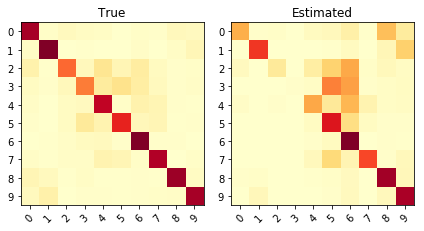

JS divergence: 0.1453	Norm Frobenius: 0.1205


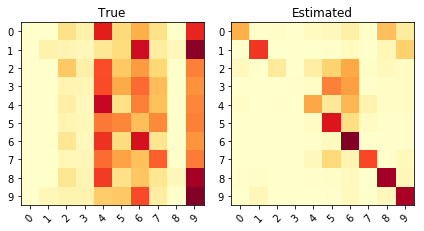

JS divergence: 0.3503	Norm Frobenius: 0.1885


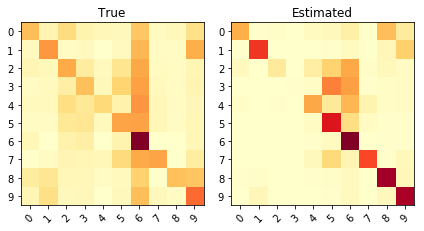

JS divergence: 0.1894	Norm Frobenius: 0.1331


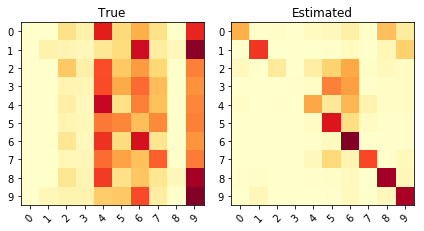

JS divergence: 0.3503	Norm Frobenius: 0.1885


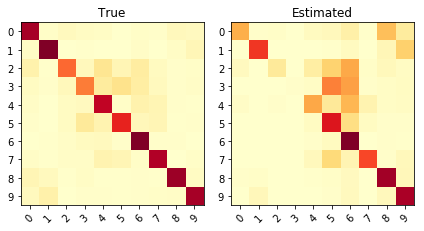

JS divergence: 0.1453	Norm Frobenius: 0.1205


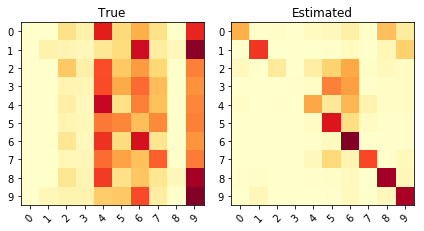

JS divergence: 0.3503	Norm Frobenius: 0.1885


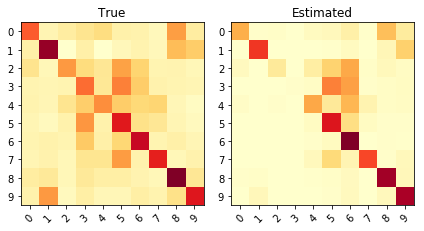

JS divergence: 0.1752	Norm Frobenius: 0.1216


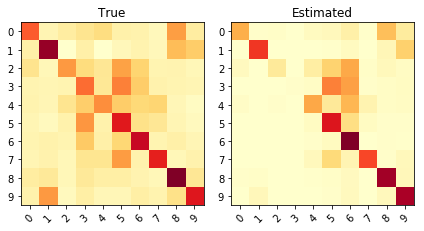

JS divergence: 0.1752	Norm Frobenius: 0.1216


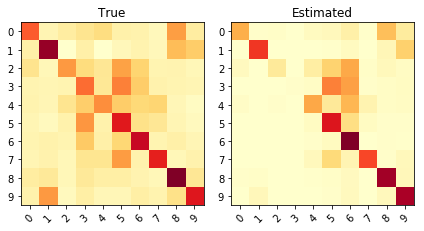

JS divergence: 0.1752	Norm Frobenius: 0.1216


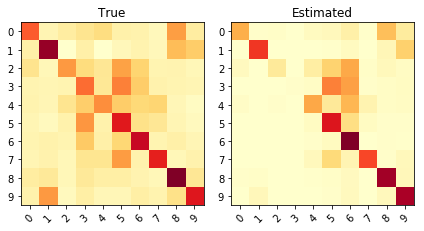

JS divergence: 0.1752	Norm Frobenius: 0.1216


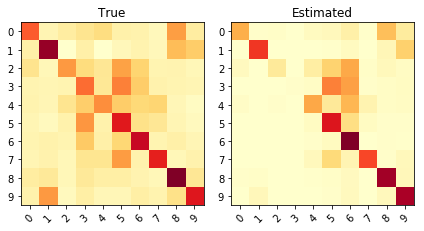

JS divergence: 0.1752	Norm Frobenius: 0.1216


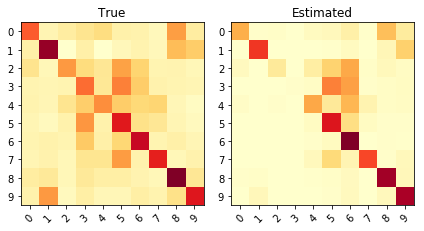

JS divergence: 0.1752	Norm Frobenius: 0.1216


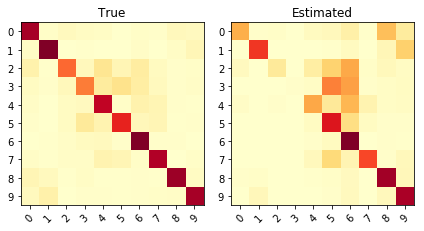

JS divergence: 0.1453	Norm Frobenius: 0.1205


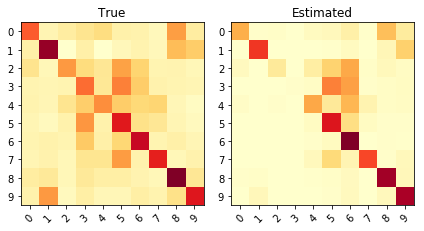

JS divergence: 0.1752	Norm Frobenius: 0.1216


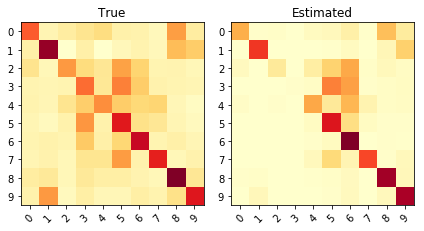

JS divergence: 0.1752	Norm Frobenius: 0.1216
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.55398       0.55398      0.135821   0.203741       0.135776    0.203605
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.5387        0.5387
====  ======  ==========  ============


In [15]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


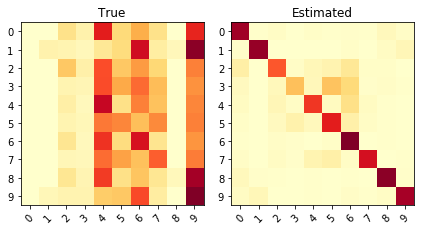

JS divergence: 0.4530	Norm Frobenius: 0.2260


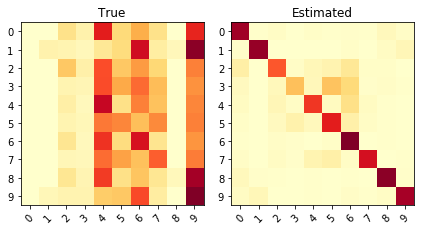

JS divergence: 0.4530	Norm Frobenius: 0.2260


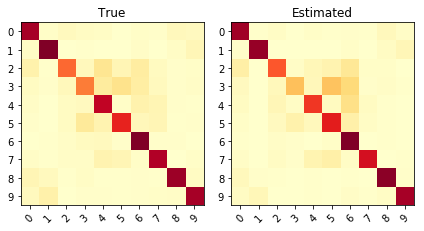

JS divergence: 0.0221	Norm Frobenius: 0.0376


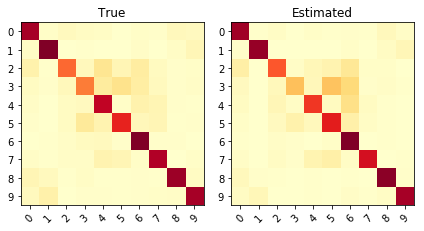

JS divergence: 0.0221	Norm Frobenius: 0.0376


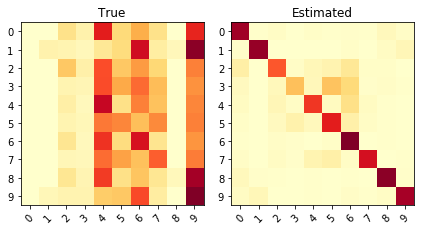

JS divergence: 0.4530	Norm Frobenius: 0.2260


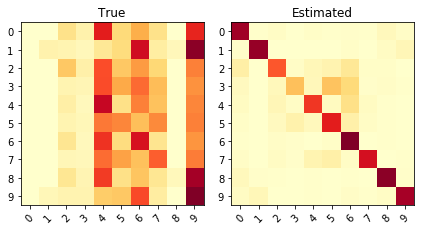

JS divergence: 0.4530	Norm Frobenius: 0.2260


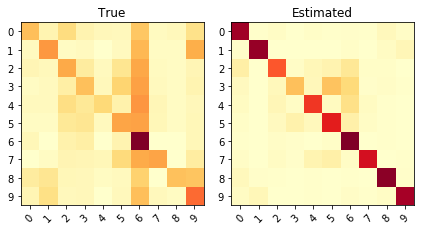

JS divergence: 0.2116	Norm Frobenius: 0.1648


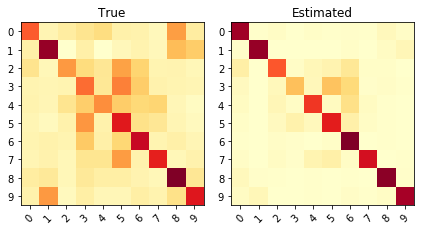

JS divergence: 0.1706	Norm Frobenius: 0.1426


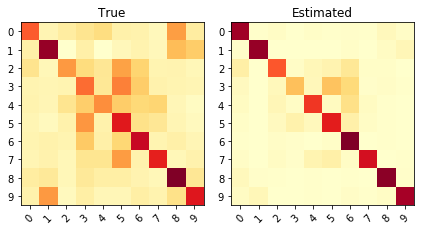

JS divergence: 0.1706	Norm Frobenius: 0.1426


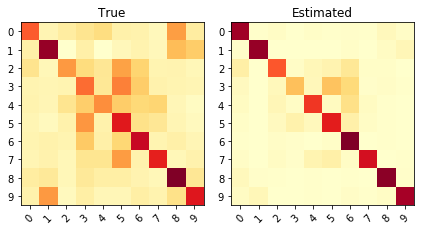

JS divergence: 0.1706	Norm Frobenius: 0.1426


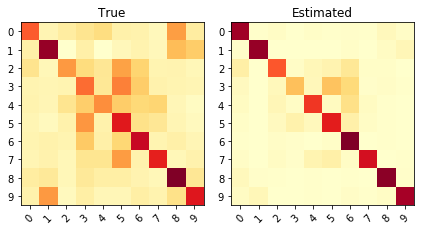

JS divergence: 0.1706	Norm Frobenius: 0.1426


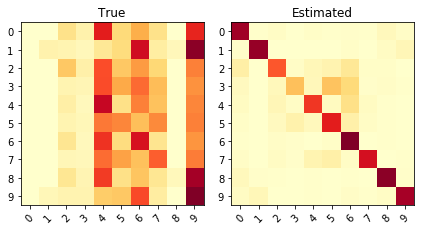

JS divergence: 0.4530	Norm Frobenius: 0.2260


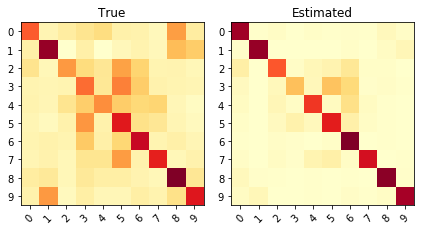

JS divergence: 0.1706	Norm Frobenius: 0.1426


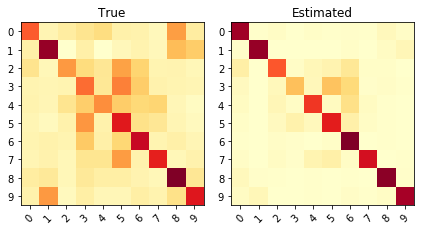

JS divergence: 0.1706	Norm Frobenius: 0.1426


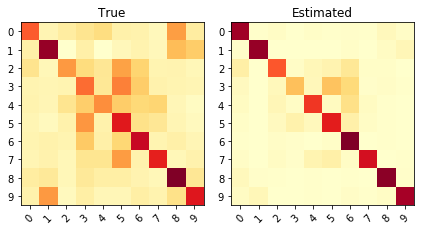

JS divergence: 0.1706	Norm Frobenius: 0.1426
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.74692       0.74692      0.141252   0.200328       0.141133    0.200049
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7136        0.7136
====  ======  ==========  ============


In [17]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


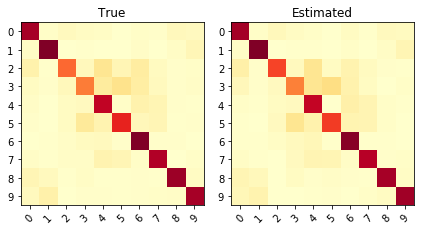

JS divergence: 0.0061	Norm Frobenius: 0.0134


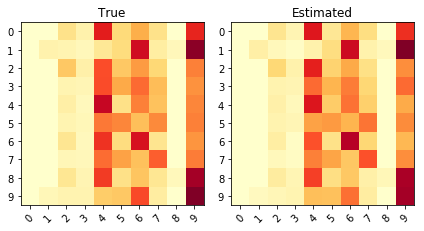

JS divergence: 0.0038	Norm Frobenius: 0.0163


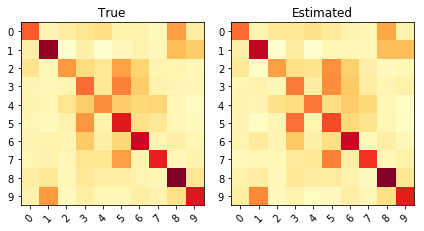

JS divergence: 0.0047	Norm Frobenius: 0.0161


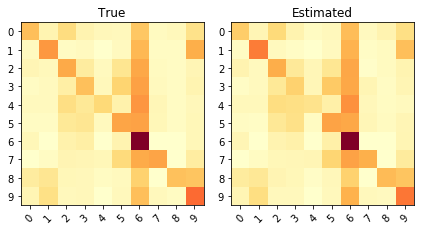

JS divergence: 0.0038	Norm Frobenius: 0.0145


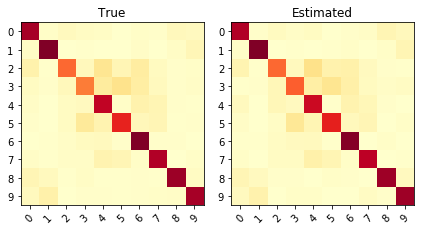

JS divergence: 0.0056	Norm Frobenius: 0.0107


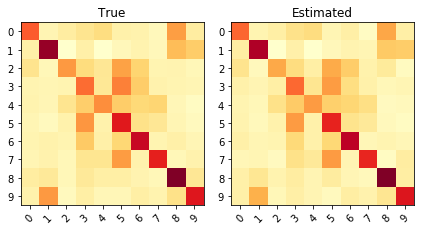

JS divergence: 0.0037	Norm Frobenius: 0.0126


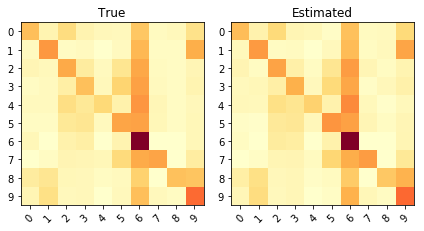

JS divergence: 0.0044	Norm Frobenius: 0.0123


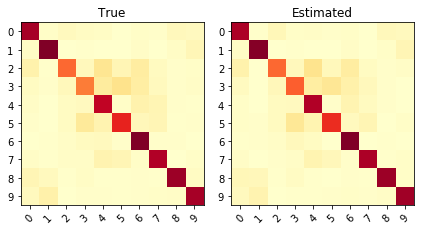

JS divergence: 0.0049	Norm Frobenius: 0.0105


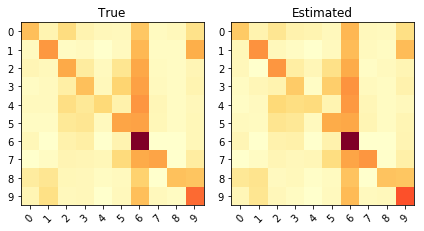

JS divergence: 0.0059	Norm Frobenius: 0.0151


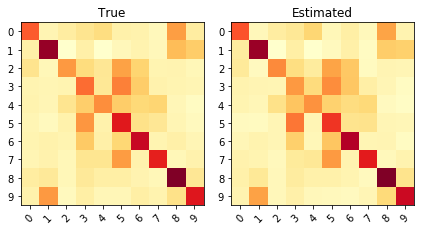

JS divergence: 0.0052	Norm Frobenius: 0.0158


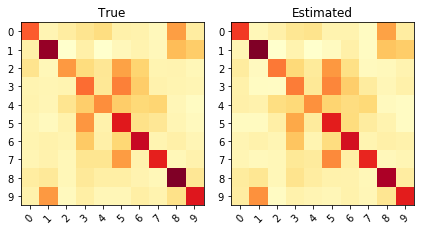

JS divergence: 0.0051	Norm Frobenius: 0.0151


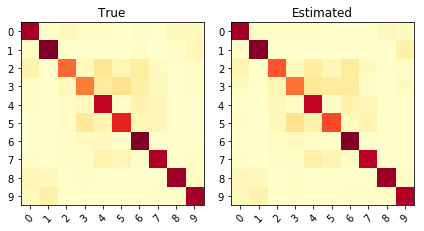

JS divergence: 0.0057	Norm Frobenius: 0.0141


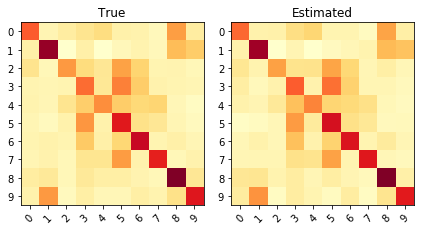

JS divergence: 0.0052	Norm Frobenius: 0.0132


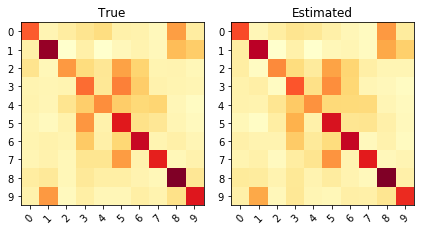

JS divergence: 0.0050	Norm Frobenius: 0.0145


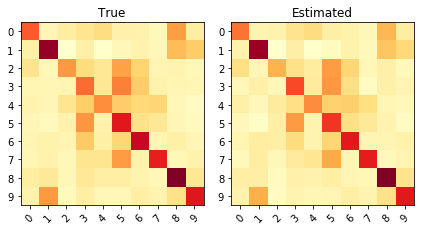

JS divergence: 0.0046	Norm Frobenius: 0.0154
A result
 ====  ======  ==========  ============  ============  ==========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF     Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  ==========  =============  ==========
   0  Global     0.79976       0.79976     0.0140253  0.00442628      0.0140218  0.00442627
====  ======  ==========  ============  ============  ==========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7579        0.7579
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


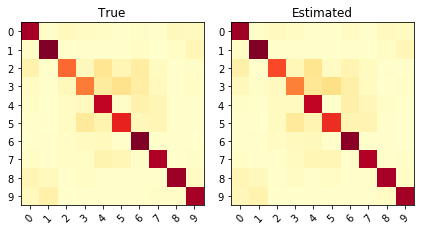

JS divergence: 0.0048	Norm Frobenius: 0.0120


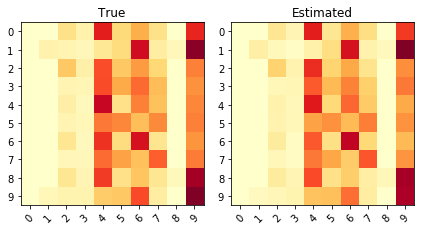

JS divergence: 0.0053	Norm Frobenius: 0.0141


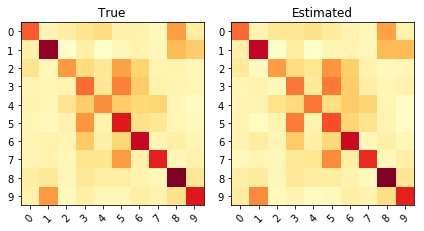

JS divergence: 0.0036	Norm Frobenius: 0.0149


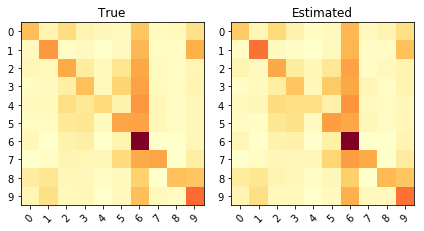

JS divergence: 0.0039	Norm Frobenius: 0.0137


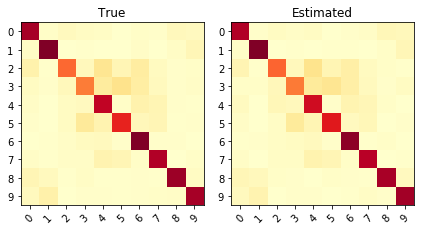

JS divergence: 0.0035	Norm Frobenius: 0.0093


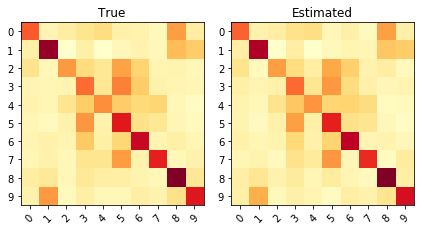

JS divergence: 0.0033	Norm Frobenius: 0.0114


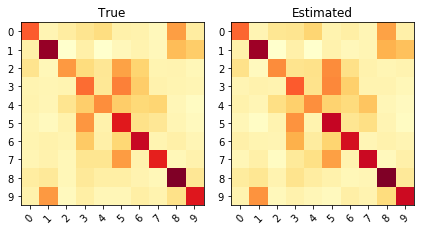

JS divergence: 0.0033	Norm Frobenius: 0.0129


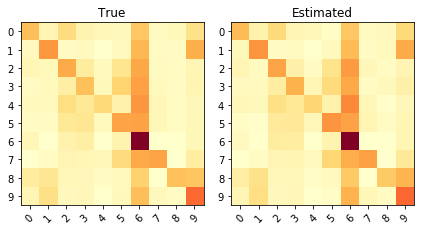

JS divergence: 0.0041	Norm Frobenius: 0.0120


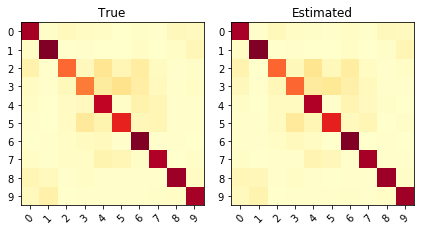

JS divergence: 0.0027	Norm Frobenius: 0.0082


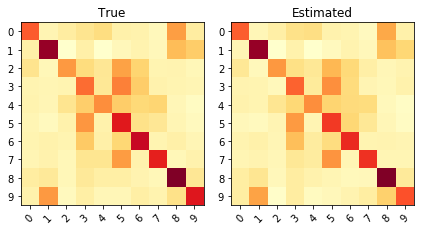

JS divergence: 0.0038	Norm Frobenius: 0.0145


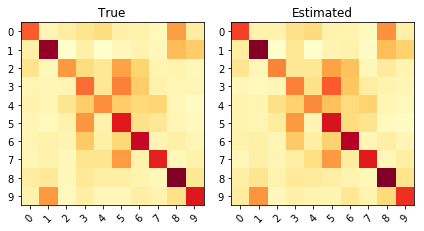

JS divergence: 0.0037	Norm Frobenius: 0.0130


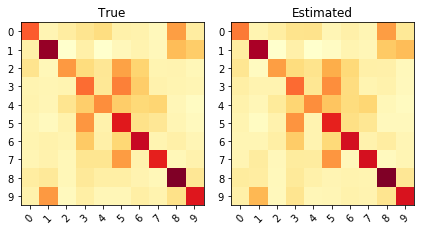

JS divergence: 0.0037	Norm Frobenius: 0.0128


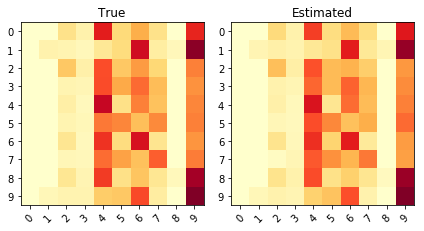

JS divergence: 0.0048	Norm Frobenius: 0.0129


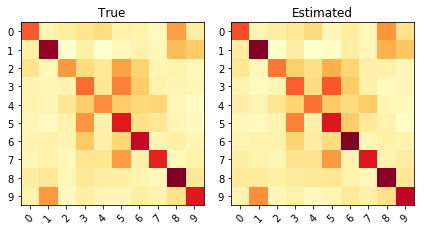

JS divergence: 0.0039	Norm Frobenius: 0.0139


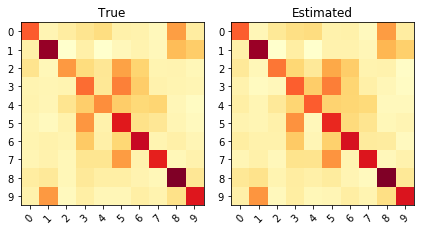

JS divergence: 0.0046	Norm Frobenius: 0.0140
A result
 ====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF     Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
   0  Global     0.84726       0.84726     0.0129332  0.00416874      0.0129301  0.00416691     0.238542      0.238482
====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.399878 

In [20]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


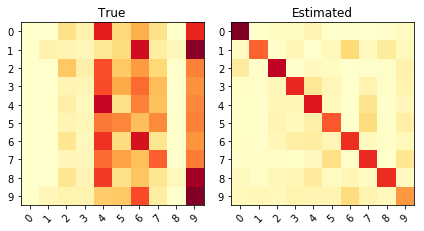

JS divergence: 0.3137	Norm Frobenius: 0.1788


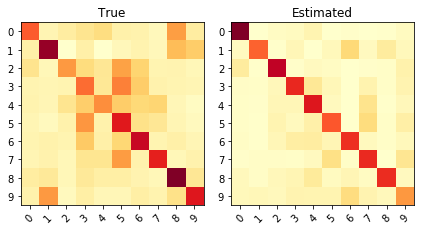

JS divergence: 0.1448	Norm Frobenius: 0.1151


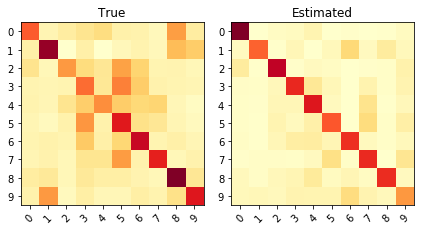

JS divergence: 0.1448	Norm Frobenius: 0.1151


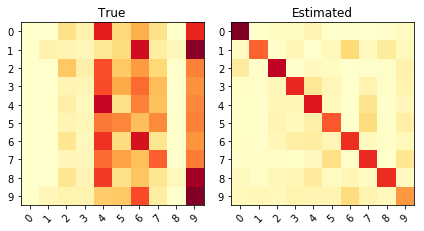

JS divergence: 0.3137	Norm Frobenius: 0.1788


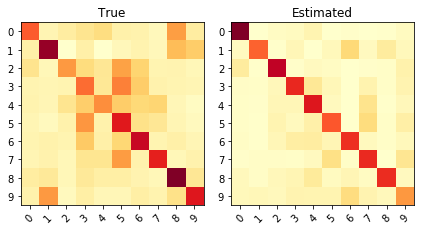

JS divergence: 0.1448	Norm Frobenius: 0.1151


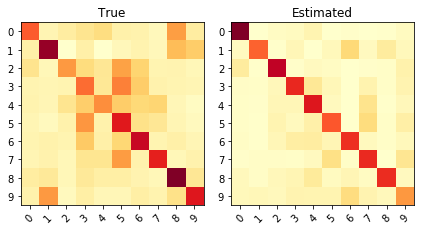

JS divergence: 0.1448	Norm Frobenius: 0.1151


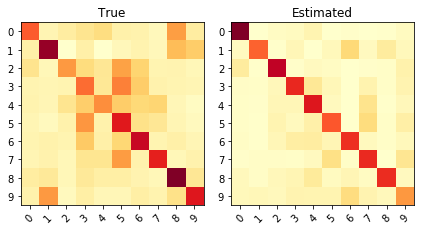

JS divergence: 0.1448	Norm Frobenius: 0.1151


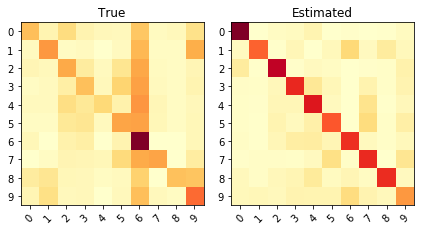

JS divergence: 0.2126	Norm Frobenius: 0.1421


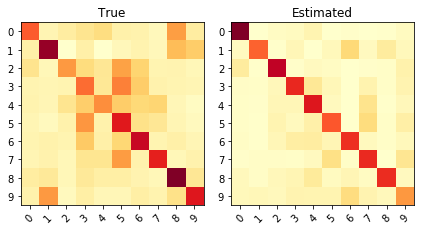

JS divergence: 0.1448	Norm Frobenius: 0.1151


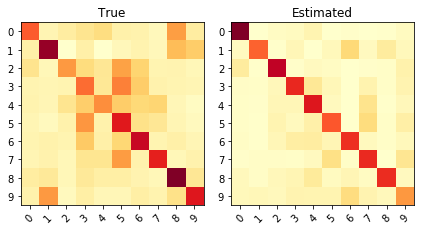

JS divergence: 0.1448	Norm Frobenius: 0.1151


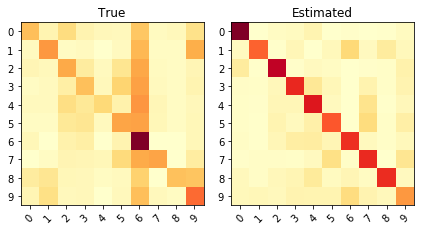

JS divergence: 0.2126	Norm Frobenius: 0.1421


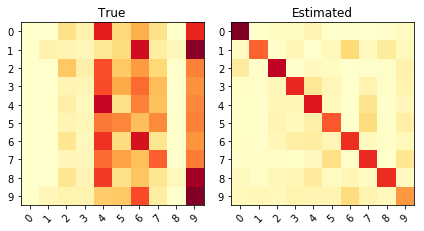

JS divergence: 0.3137	Norm Frobenius: 0.1788


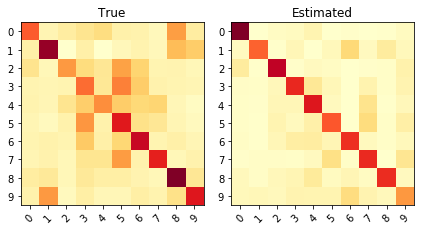

JS divergence: 0.1448	Norm Frobenius: 0.1151


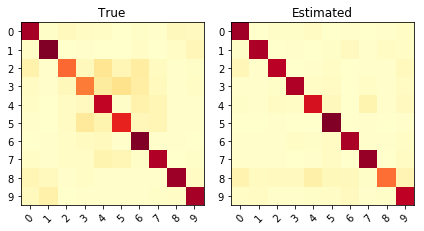

JS divergence: 0.0774	Norm Frobenius: 0.0787


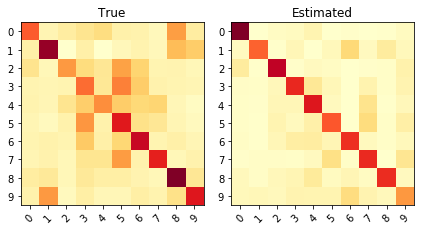

JS divergence: 0.1448	Norm Frobenius: 0.1151
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global     0.76964       0.76964      0.124928   0.175946       0.124866      0.1758     0.436876      0.436472
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.378682      

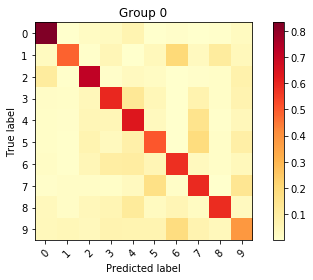

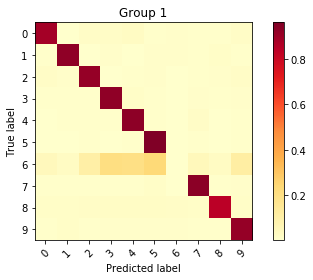

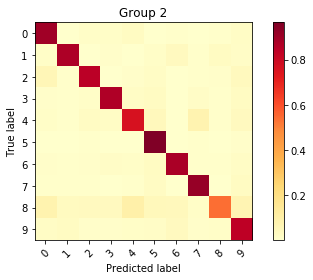

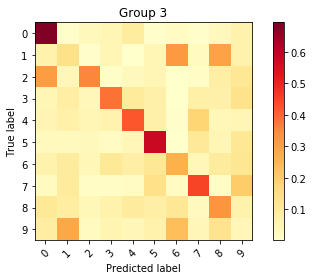

Inertia: 0.15746819385384433
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.357785      35   1.38389      0.592185   0.543839       0.643284   0.546872      0.7606        0.7606
   1         1  0.165536      16   0.601419     0.826103   0.686917       0.802007   0.806781      0.6948        0.6948
   2         2  0.311023      31   0.720445     0.837867   0.187627       0.870816   0.819852      0.6937        0.6937
   3         3  0.165656      16   1.77463      0.365012   1.21538        0.340247   0.294458      0.5623        0.5623
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A

In [23]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


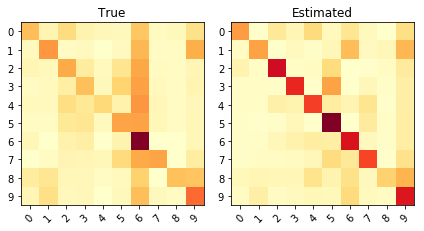

KL divergence: 0.6291	Pearson Correlation between diagonals: 0.2931


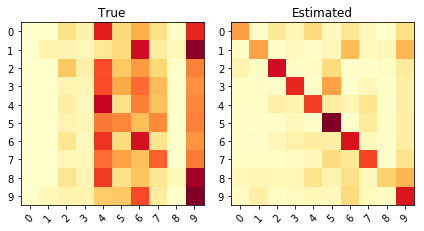

KL divergence: 0.7560	Pearson Correlation between diagonals: 0.5607


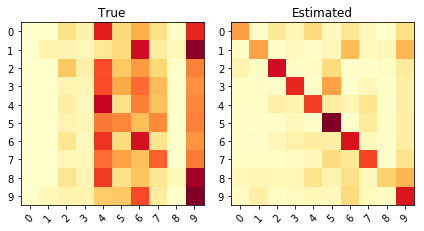

KL divergence: 0.7560	Pearson Correlation between diagonals: 0.5607


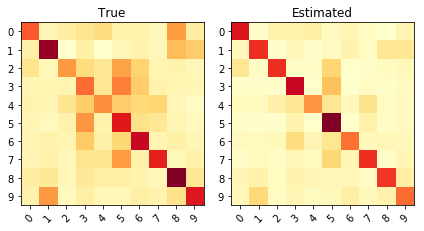

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


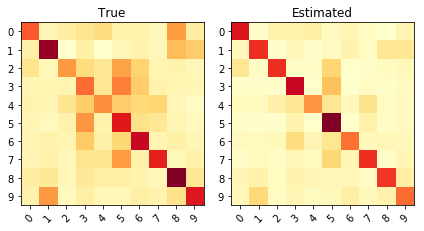

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


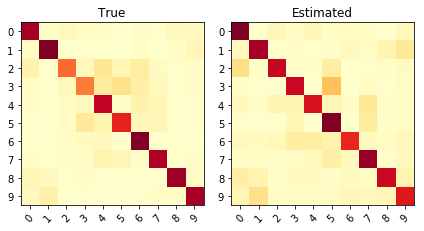

KL divergence: 0.2739	Pearson Correlation between diagonals: -0.0884


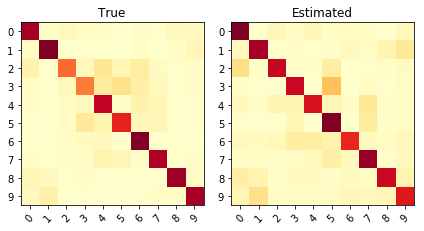

KL divergence: 0.2739	Pearson Correlation between diagonals: -0.0884


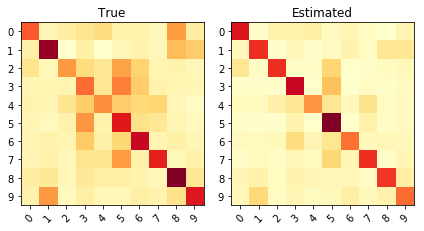

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


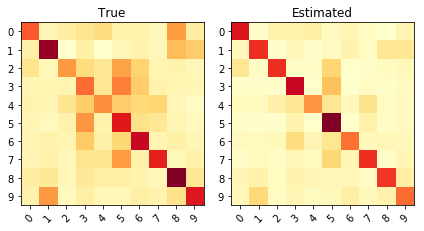

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


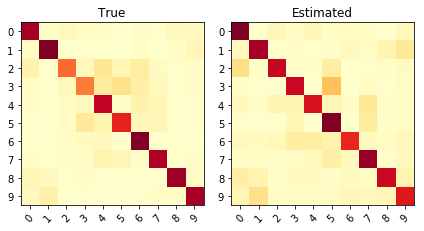

KL divergence: 0.2739	Pearson Correlation between diagonals: -0.0884


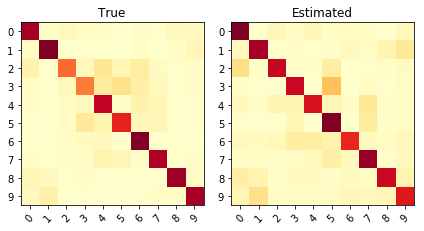

KL divergence: 0.2739	Pearson Correlation between diagonals: -0.0884


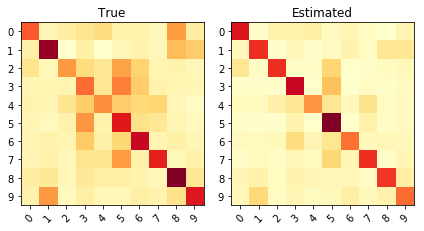

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042


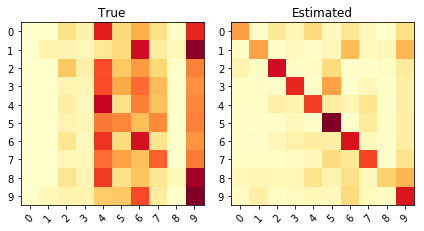

KL divergence: 0.7560	Pearson Correlation between diagonals: 0.5607


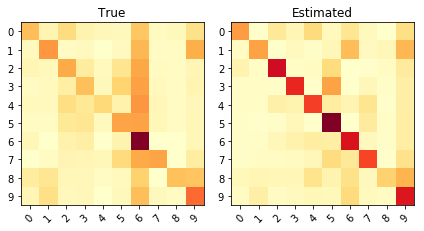

KL divergence: 0.6291	Pearson Correlation between diagonals: 0.2931


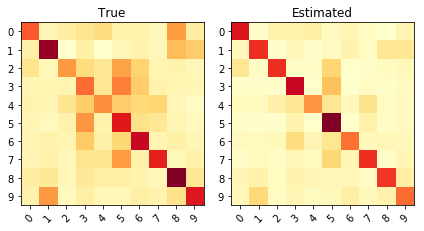

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.0042
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.81508       0.81508   0.426638  0.0669812           0.0814631       0.0284352
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.43138                 1.70306
====  =======================  ======================
Test


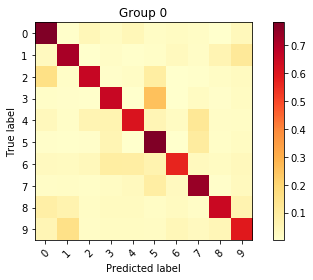

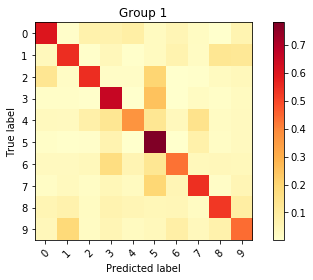

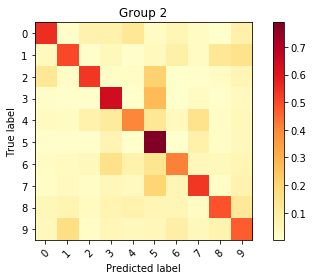

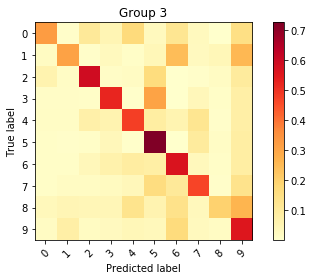

Inertia: 0.025814110830348607
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.300979      30    1.19376     0.675612   0.397962       0.813326   0.575612      0.785         0.785
   1         1  0.227161      22    1.49506     0.544456   0.628835       0.717767   0.444456      0.7849        0.7849
   2         2  0.292713      29    1.50925     0.533428   0.646549       0.710046   0.433428      0.7788        0.7788
   3         3  0.179148      17    1.57089     0.474265   0.805266       0.655534   0.374265      0.645         0.645
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A 

In [31]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


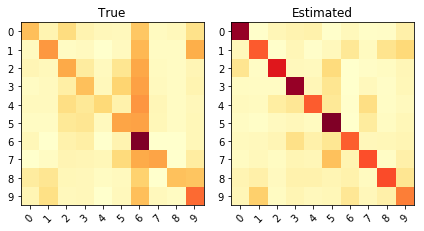

KL divergence: 0.7503	Pearson Correlation between diagonals: -0.3583


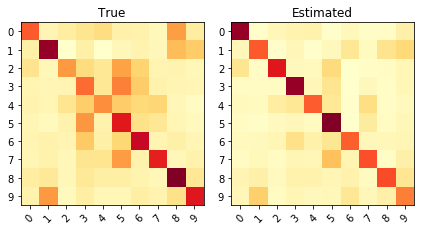

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


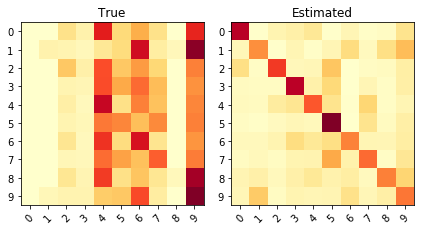

KL divergence: 0.8380	Pearson Correlation between diagonals: -0.3117


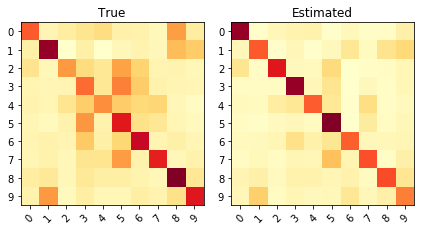

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


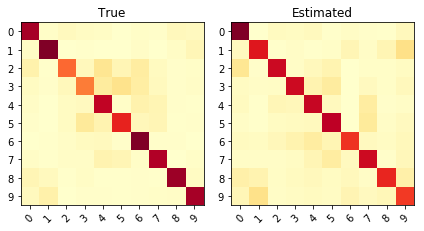

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


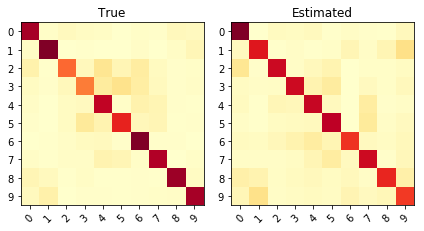

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


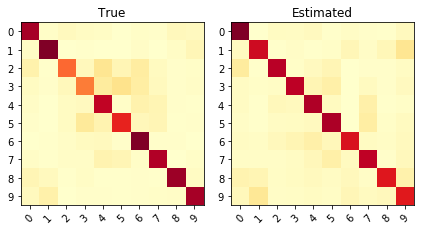

KL divergence: 0.2047	Pearson Correlation between diagonals: -0.3518


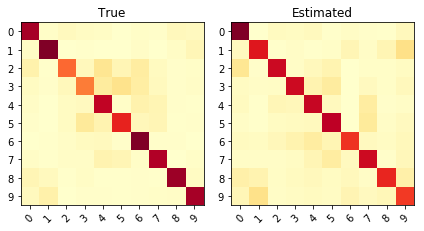

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


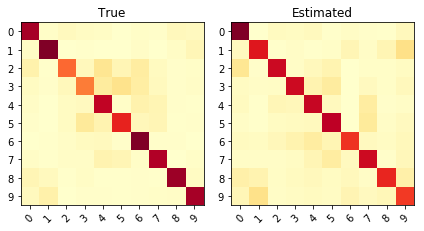

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


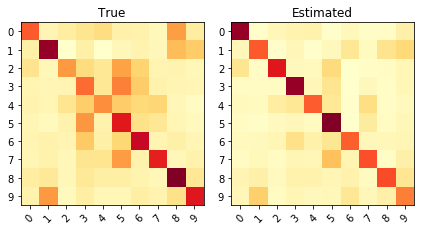

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


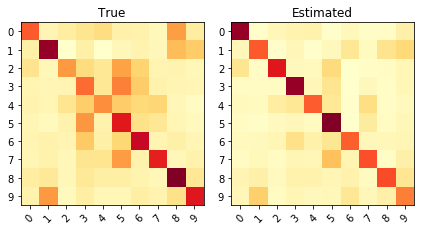

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


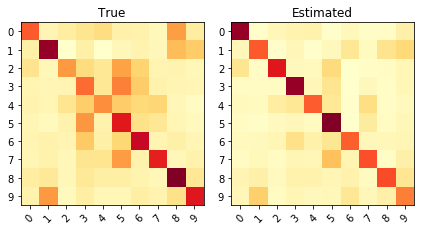

KL divergence: 0.3166	Pearson Correlation between diagonals: -0.3823


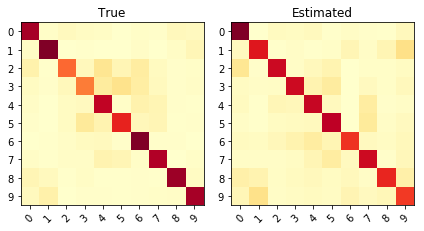

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


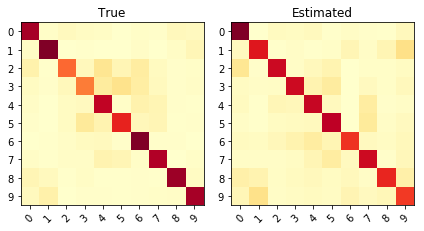

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048


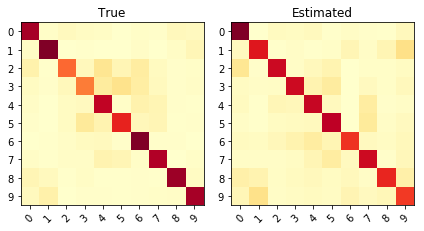

KL divergence: 0.2239	Pearson Correlation between diagonals: -0.3048
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.81666       0.81666   0.406988   0.072578           -0.349296       0.0211964
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.424882                 1.73912
====  =======================  ======================
Test


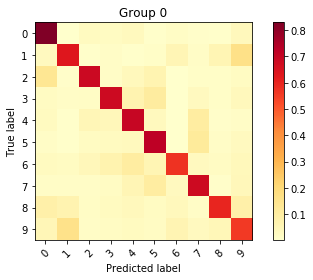

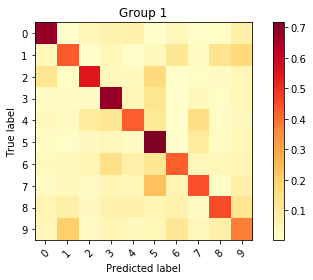

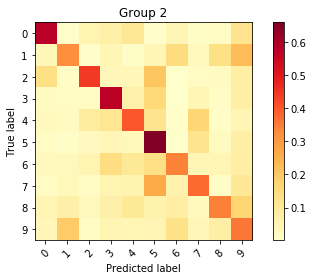

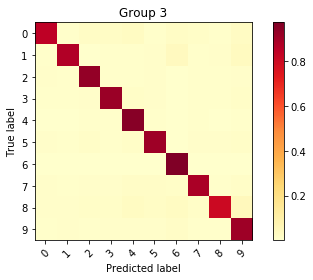

Inertia: 0.0627941859420389
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.27152       27   1.25199      0.666439   0.412113       0.807155   0.566439      0.78          0.78
   1         1  0.236346      23   1.58009      0.518576   0.682384       0.696873   0.418576      0.7778        0.7778
   2         2  0.317873      31   1.70526      0.441275   0.849152       0.633445   0.341275      0.7551        0.7551
   3         3  0.174262      17   0.519652     0.900076   0.106705       0.94766    0.800076      0.7396        0.7396
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A re

In [32]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [28]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.64792


#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [28]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7487


*** Soft-Majority (Train with softMV) ***
Train


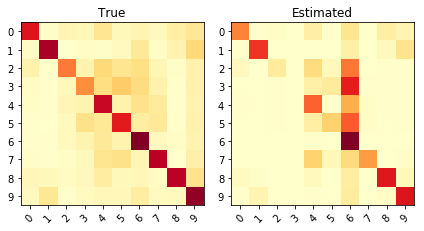

JS divergence: 0.1626	Norm Frobenius: 0.1194


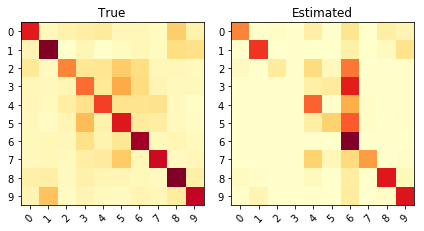

JS divergence: 0.2045	Norm Frobenius: 0.1303


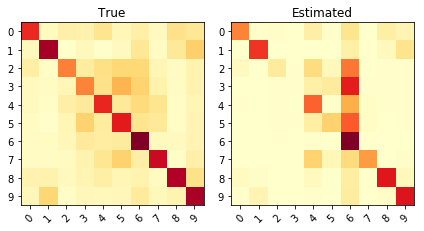

JS divergence: 0.1774	Norm Frobenius: 0.1227


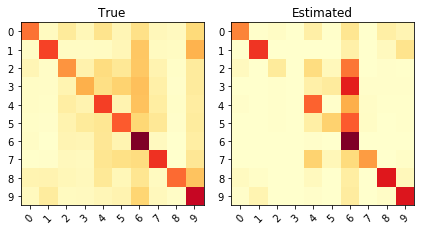

JS divergence: 0.1541	Norm Frobenius: 0.1158


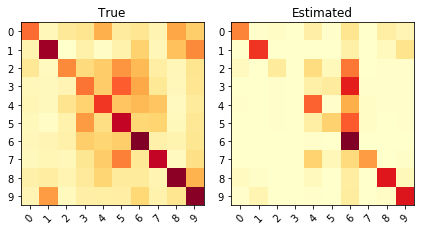

JS divergence: 0.2327	Norm Frobenius: 0.1449


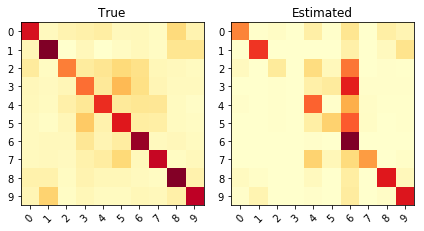

JS divergence: 0.1926	Norm Frobenius: 0.1271


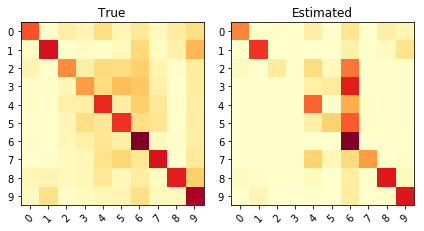

JS divergence: 0.1706	Norm Frobenius: 0.1217


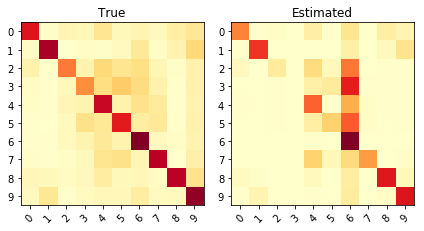

JS divergence: 0.1626	Norm Frobenius: 0.1194


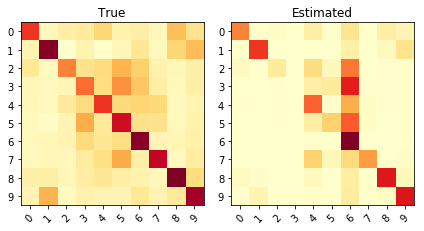

JS divergence: 0.2110	Norm Frobenius: 0.1345


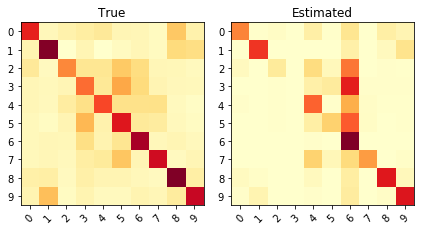

JS divergence: 0.2087	Norm Frobenius: 0.1317


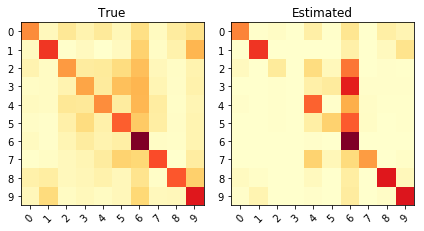

JS divergence: 0.1711	Norm Frobenius: 0.1211


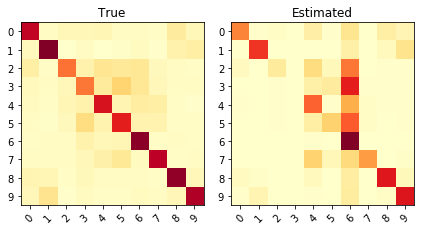

JS divergence: 0.1739	Norm Frobenius: 0.1272


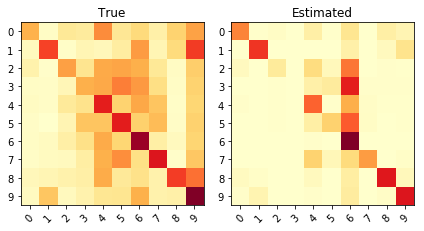

JS divergence: 0.2398	Norm Frobenius: 0.1518


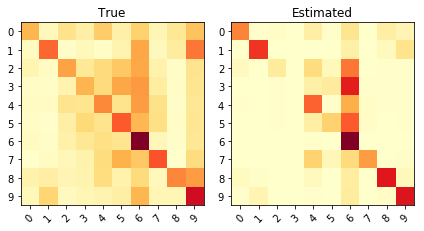

JS divergence: 0.2076	Norm Frobenius: 0.1391


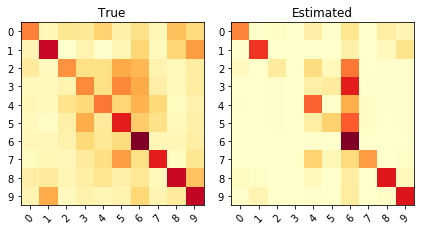

JS divergence: 0.2157	Norm Frobenius: 0.1386
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.50854       0.50854      0.129763   0.192373       0.129769    0.192409
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.5067        0.5067
====  ======  ==========  ============


In [29]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


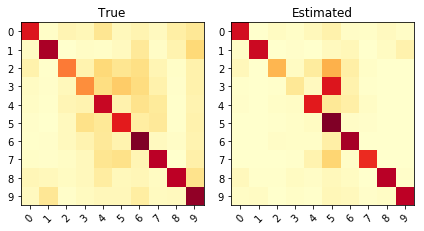

JS divergence: 0.1135	Norm Frobenius: 0.1037


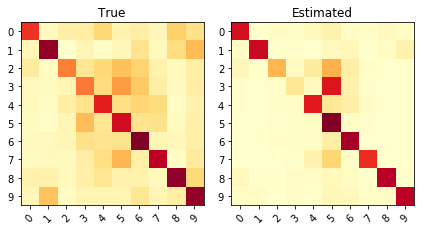

JS divergence: 0.1515	Norm Frobenius: 0.1264


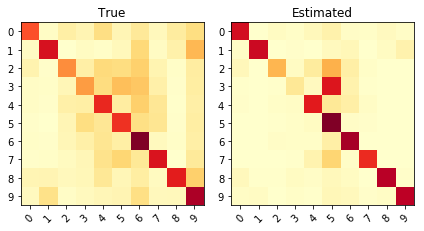

JS divergence: 0.1525	Norm Frobenius: 0.1268


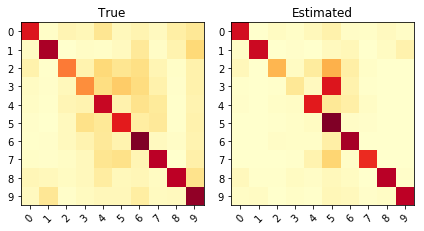

JS divergence: 0.1135	Norm Frobenius: 0.1037


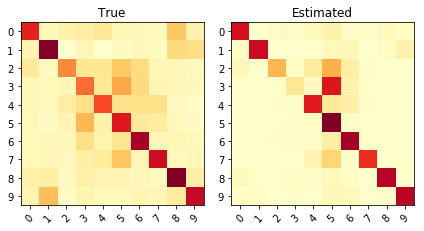

JS divergence: 0.1281	Norm Frobenius: 0.1127


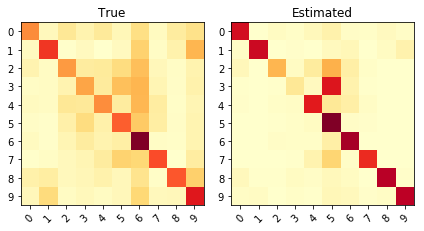

JS divergence: 0.1748	Norm Frobenius: 0.1394


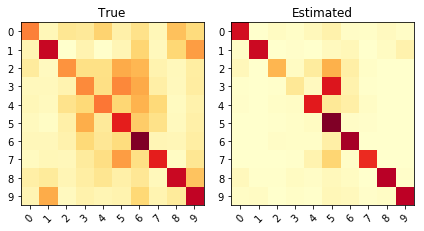

JS divergence: 0.1938	Norm Frobenius: 0.1483


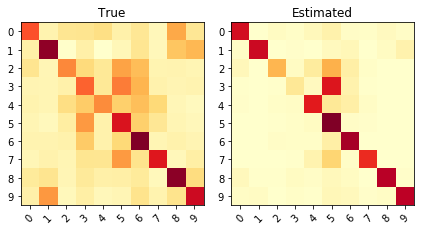

JS divergence: 0.1768	Norm Frobenius: 0.1399


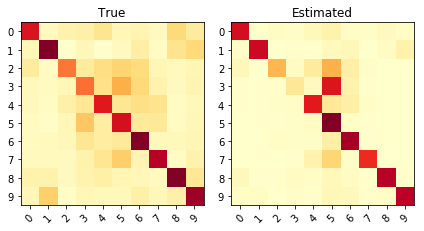

JS divergence: 0.1220	Norm Frobenius: 0.1093


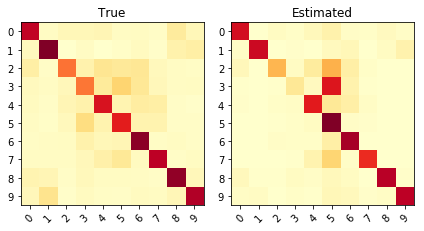

JS divergence: 0.0825	Norm Frobenius: 0.0853


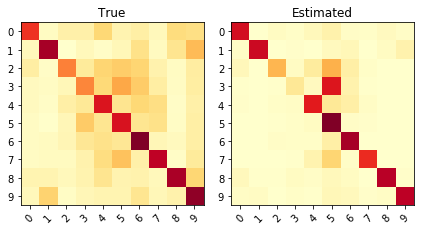

JS divergence: 0.1483	Norm Frobenius: 0.1245


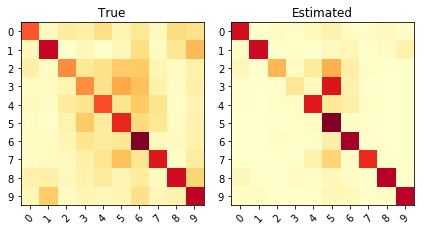

JS divergence: 0.1593	Norm Frobenius: 0.1309


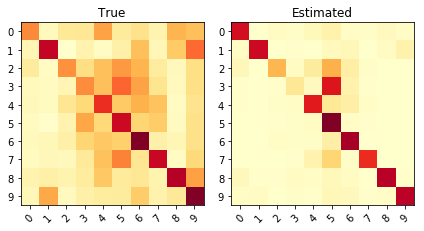

JS divergence: 0.2105	Norm Frobenius: 0.1558


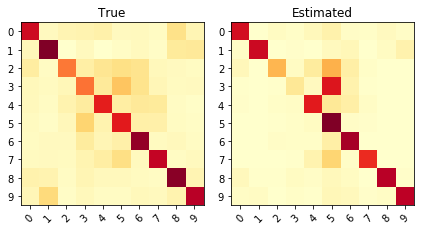

JS divergence: 0.0962	Norm Frobenius: 0.0930


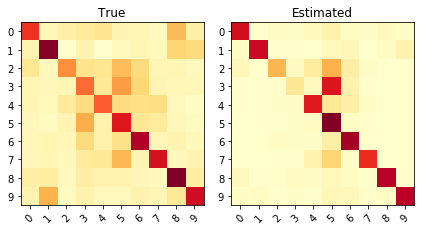

JS divergence: 0.1418	Norm Frobenius: 0.1207
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.67662       0.67662      0.131168   0.163767       0.131172     0.16377
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.6532        0.6532
====  ======  ==========  ============


In [31]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


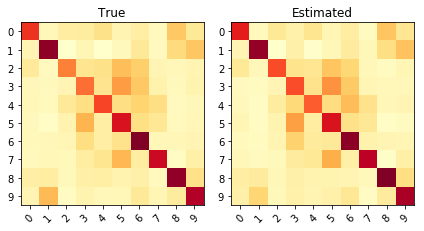

JS divergence: 0.0039	Norm Frobenius: 0.0137


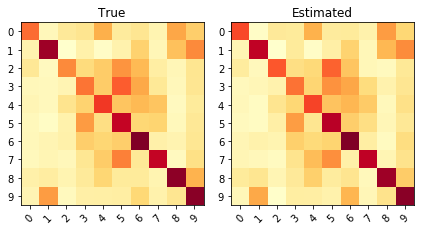

JS divergence: 0.0040	Norm Frobenius: 0.0140


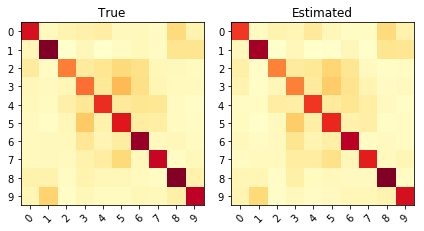

JS divergence: 0.0049	Norm Frobenius: 0.0138


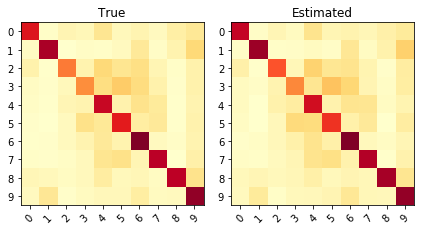

JS divergence: 0.0039	Norm Frobenius: 0.0133


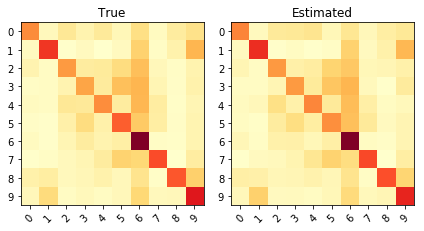

JS divergence: 0.0046	Norm Frobenius: 0.0146


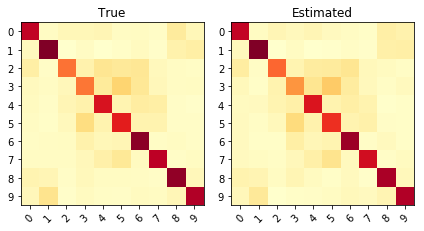

JS divergence: 0.0044	Norm Frobenius: 0.0131


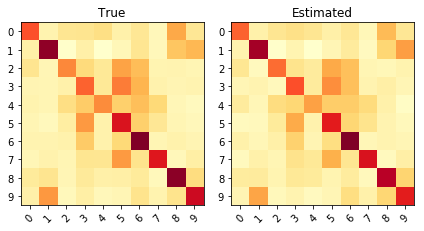

JS divergence: 0.0038	Norm Frobenius: 0.0141


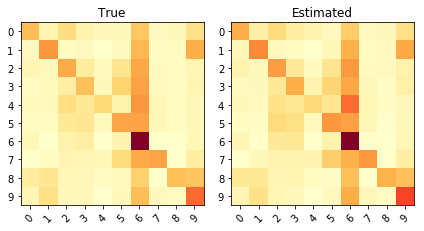

JS divergence: 0.0046	Norm Frobenius: 0.0156


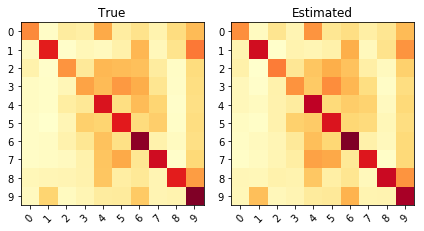

JS divergence: 0.0036	Norm Frobenius: 0.0141


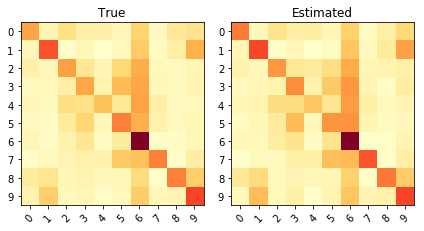

JS divergence: 0.0055	Norm Frobenius: 0.0169


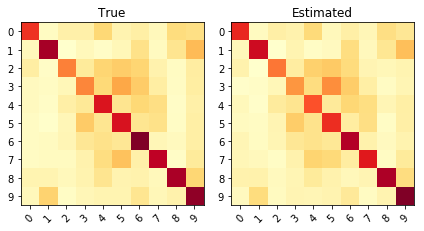

JS divergence: 0.0049	Norm Frobenius: 0.0162


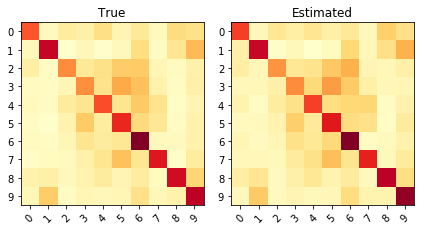

JS divergence: 0.0041	Norm Frobenius: 0.0134


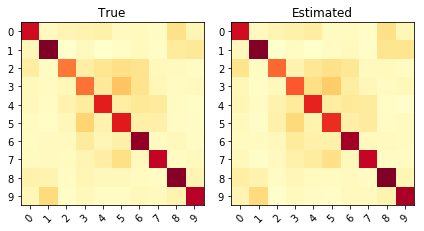

JS divergence: 0.0037	Norm Frobenius: 0.0129


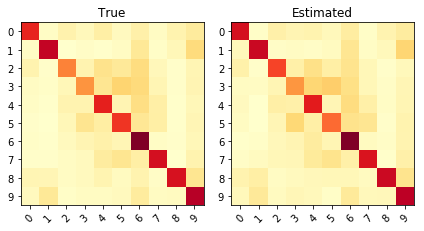

JS divergence: 0.0062	Norm Frobenius: 0.0184


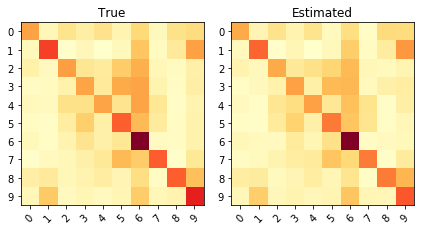

JS divergence: 0.0056	Norm Frobenius: 0.0157
A result
 ====  ======  ==========  ============  ============  ==========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF     Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  ==========  =============  ==========
   0  Global     0.73942       0.73942     0.0155667  0.00491328      0.0155669   0.0049124
====  ======  ==========  ============  ============  ==========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7177        0.7177
====  ======  ==========  ============


In [33]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


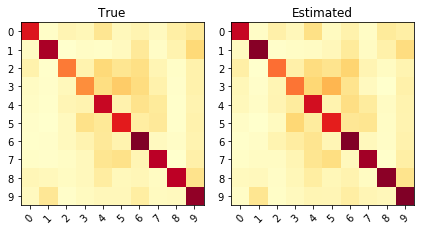

JS divergence: 0.0047	Norm Frobenius: 0.0141


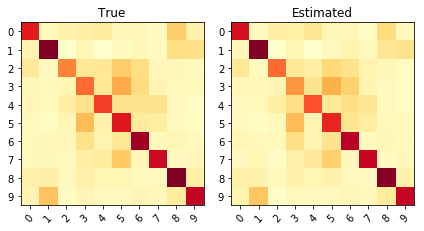

JS divergence: 0.0036	Norm Frobenius: 0.0135


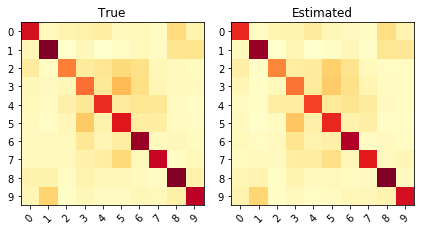

JS divergence: 0.0035	Norm Frobenius: 0.0121


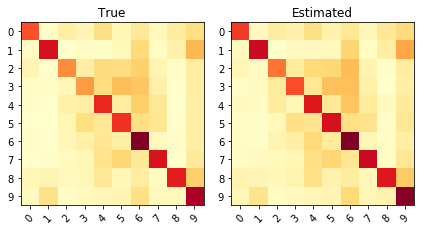

JS divergence: 0.0035	Norm Frobenius: 0.0138


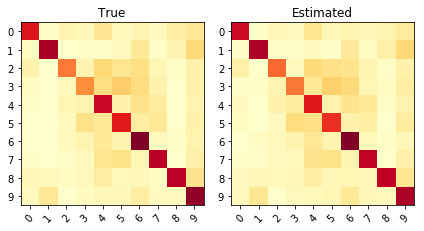

JS divergence: 0.0038	Norm Frobenius: 0.0133


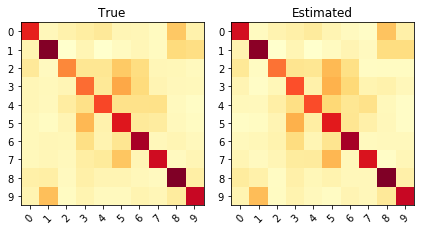

JS divergence: 0.0039	Norm Frobenius: 0.0119


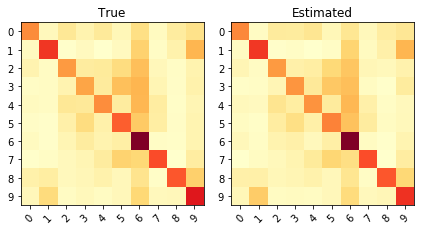

JS divergence: 0.0035	Norm Frobenius: 0.0126


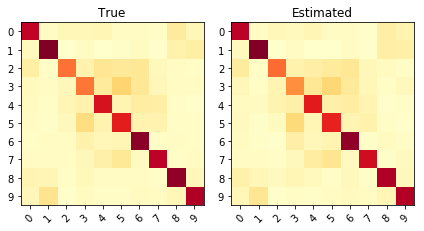

JS divergence: 0.0043	Norm Frobenius: 0.0137


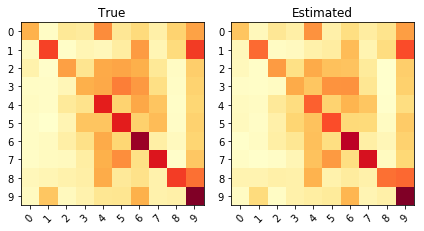

JS divergence: 0.0039	Norm Frobenius: 0.0140


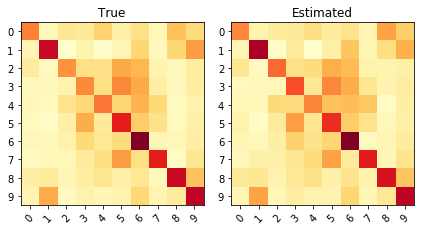

JS divergence: 0.0041	Norm Frobenius: 0.0144


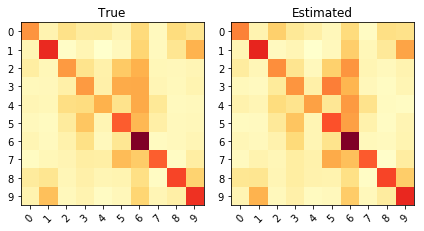

JS divergence: 0.0038	Norm Frobenius: 0.0144


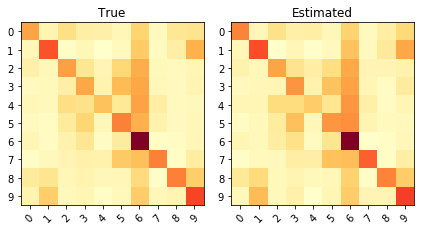

JS divergence: 0.0046	Norm Frobenius: 0.0162


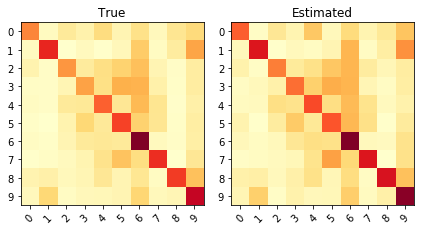

JS divergence: 0.0044	Norm Frobenius: 0.0150


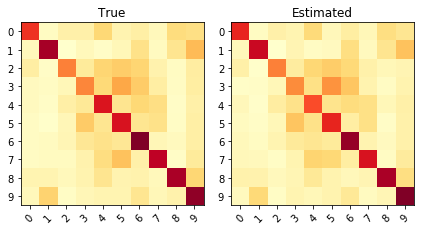

JS divergence: 0.0038	Norm Frobenius: 0.0142


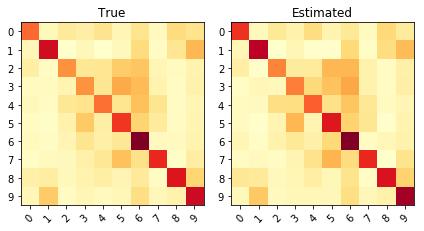

JS divergence: 0.0037	Norm Frobenius: 0.0146
A result
 ====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF     Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
   0  Global     0.81214       0.81214     0.0145338  0.00409149       0.014532  0.00409059     0.322374      0.322483
====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.368329 

In [37]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [43]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

AttributeError: 'GroupMixtureOpt' object has no attribute 'N'

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [15]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.85384


*** Soft-Majority (Train with softMV) ***
Train


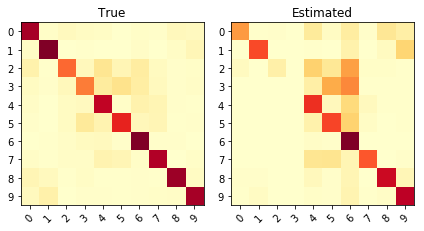

JS divergence: 0.1375	Norm Frobenius: 0.1101


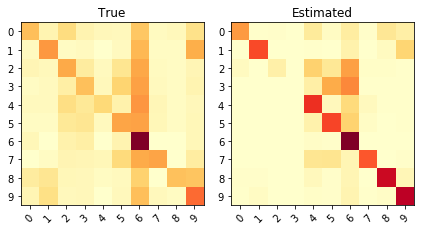

JS divergence: 0.2056	Norm Frobenius: 0.1331


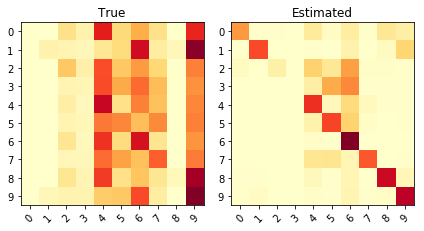

JS divergence: 0.3143	Norm Frobenius: 0.1795


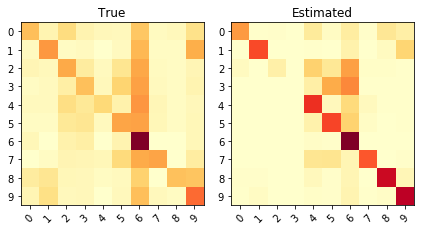

JS divergence: 0.2056	Norm Frobenius: 0.1331


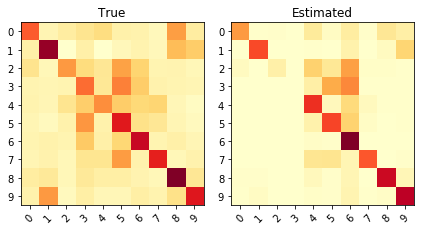

JS divergence: 0.2091	Norm Frobenius: 0.1290


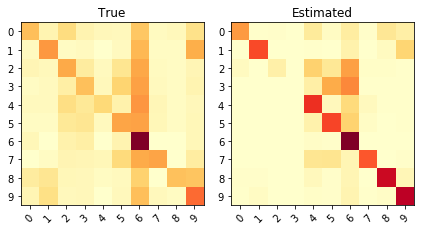

JS divergence: 0.2056	Norm Frobenius: 0.1331


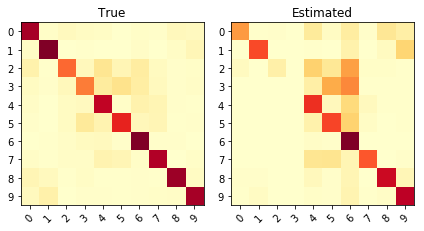

JS divergence: 0.1375	Norm Frobenius: 0.1101


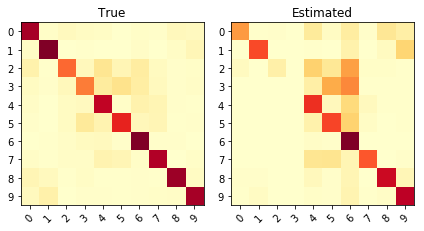

JS divergence: 0.1375	Norm Frobenius: 0.1101


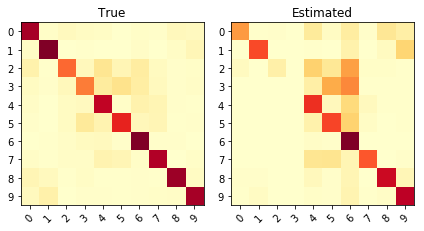

JS divergence: 0.1375	Norm Frobenius: 0.1101


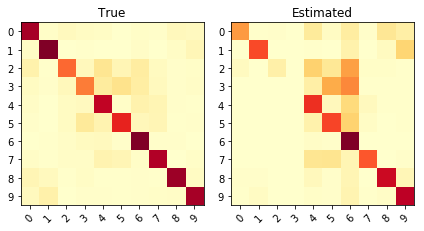

JS divergence: 0.1375	Norm Frobenius: 0.1101


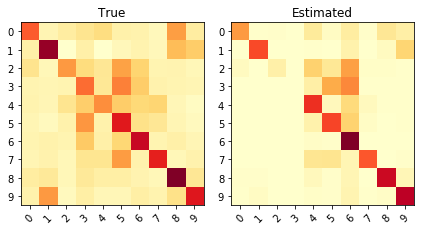

JS divergence: 0.2091	Norm Frobenius: 0.1290


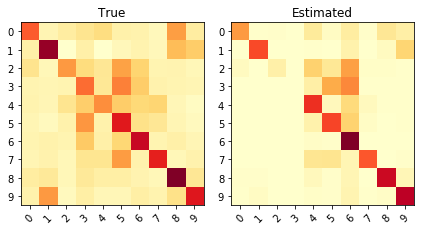

JS divergence: 0.2091	Norm Frobenius: 0.1290


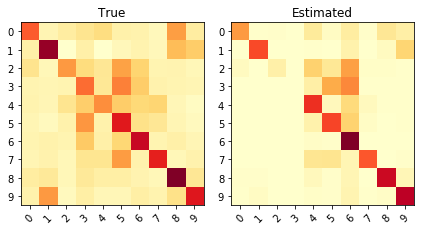

JS divergence: 0.2091	Norm Frobenius: 0.1290


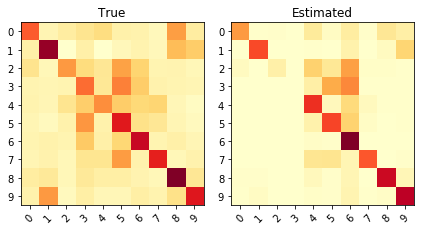

JS divergence: 0.2091	Norm Frobenius: 0.1290


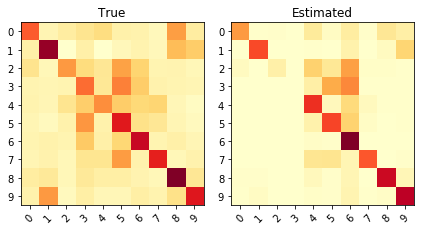

JS divergence: 0.2091	Norm Frobenius: 0.1290
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.56636       0.56636      0.136273   0.216035       0.136275    0.216048
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.5566        0.5566
====  ======  ==========  ============


In [16]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


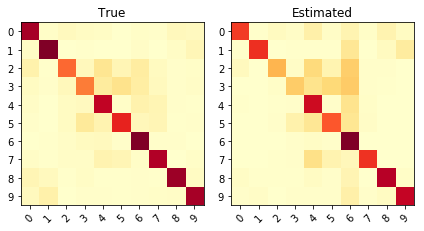

JS divergence: 0.0549	Norm Frobenius: 0.0594


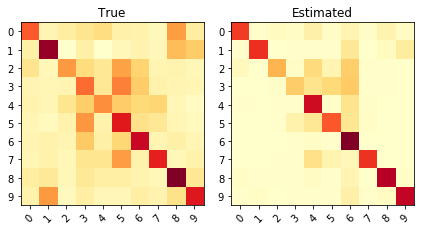

JS divergence: 0.1771	Norm Frobenius: 0.1271


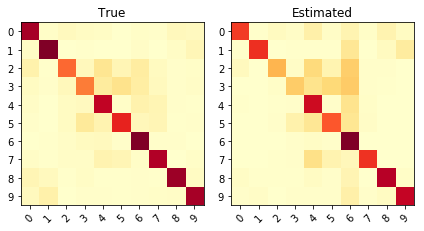

JS divergence: 0.0549	Norm Frobenius: 0.0594


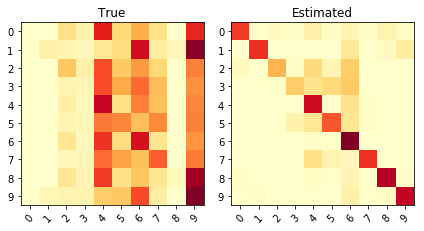

JS divergence: 0.3396	Norm Frobenius: 0.1916


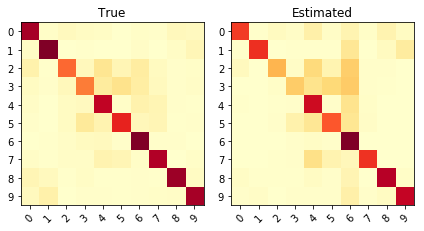

JS divergence: 0.0549	Norm Frobenius: 0.0594


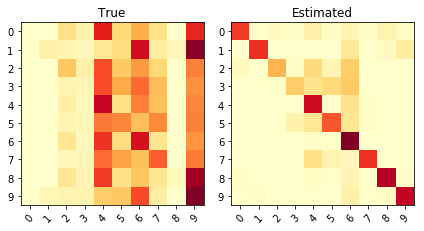

JS divergence: 0.3396	Norm Frobenius: 0.1916


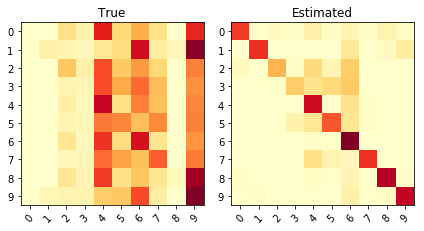

JS divergence: 0.3396	Norm Frobenius: 0.1916


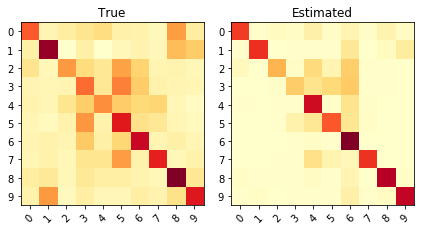

JS divergence: 0.1771	Norm Frobenius: 0.1271


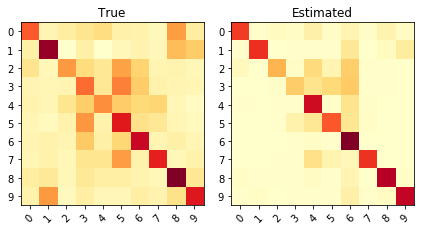

JS divergence: 0.1771	Norm Frobenius: 0.1271


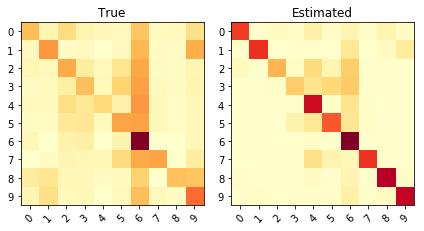

JS divergence: 0.1895	Norm Frobenius: 0.1408


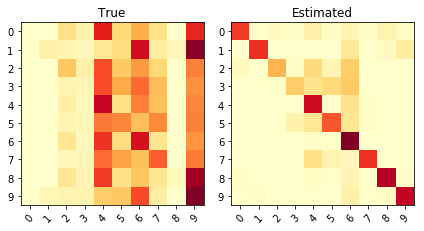

JS divergence: 0.3396	Norm Frobenius: 0.1916


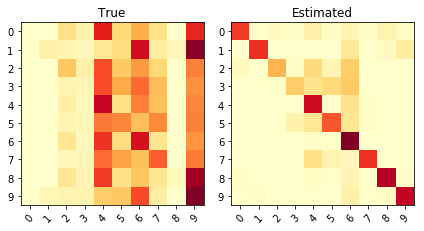

JS divergence: 0.3396	Norm Frobenius: 0.1916


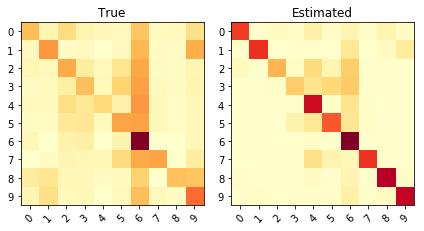

JS divergence: 0.1895	Norm Frobenius: 0.1408


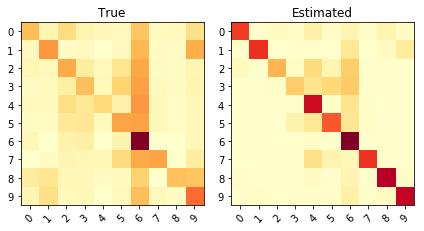

JS divergence: 0.1895	Norm Frobenius: 0.1408


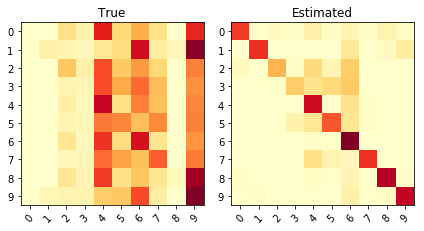

JS divergence: 0.3396	Norm Frobenius: 0.1916
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.65862       0.65862      0.128125   0.186335       0.128133    0.186343
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.6343        0.6343
====  ======  ==========  ============


In [19]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


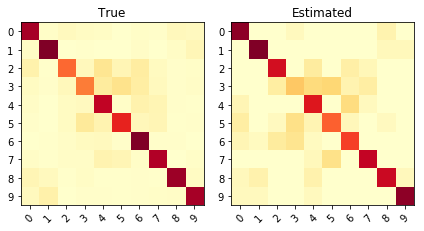

JS divergence: 0.0757	Norm Frobenius: 0.0585


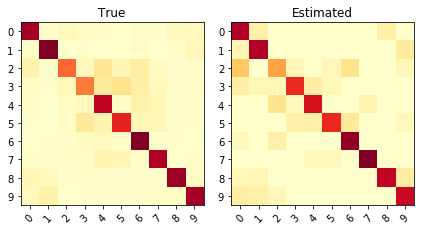

JS divergence: 0.0856	Norm Frobenius: 0.0508


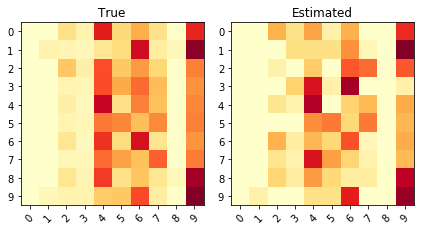

JS divergence: 0.0806	Norm Frobenius: 0.0633


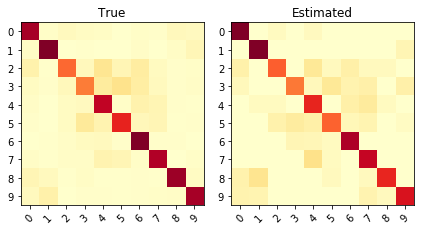

JS divergence: 0.0527	Norm Frobenius: 0.0389


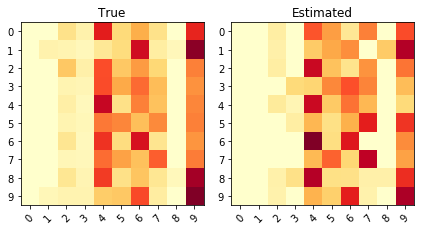

JS divergence: 0.0564	Norm Frobenius: 0.0531


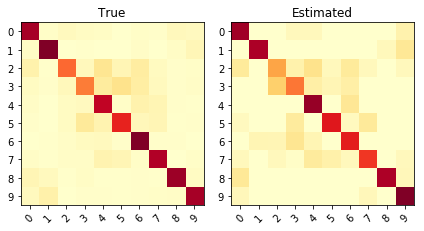

JS divergence: 0.0692	Norm Frobenius: 0.0516


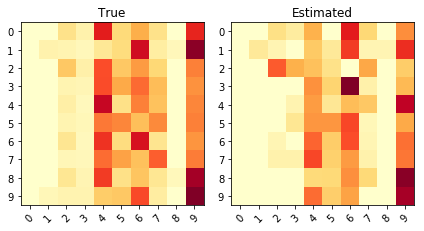

JS divergence: 0.0817	Norm Frobenius: 0.0708


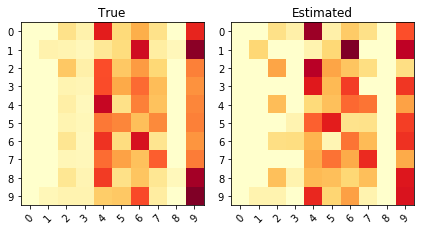

JS divergence: 0.0604	Norm Frobenius: 0.0591


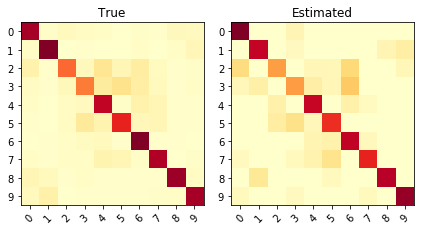

JS divergence: 0.0814	Norm Frobenius: 0.0491


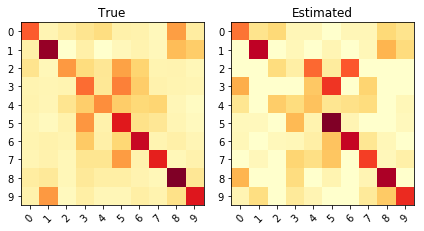

JS divergence: 0.1385	Norm Frobenius: 0.0784


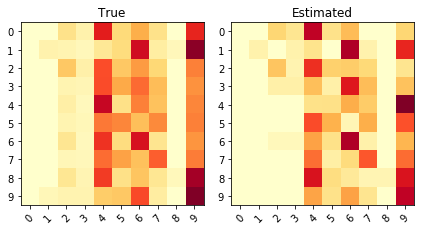

JS divergence: 0.0620	Norm Frobenius: 0.0630


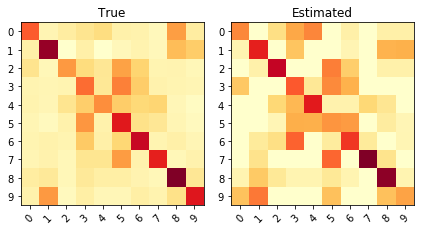

JS divergence: 0.1299	Norm Frobenius: 0.0709


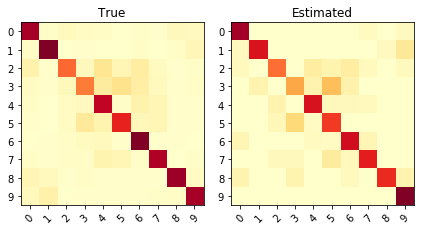

JS divergence: 0.0735	Norm Frobenius: 0.0467


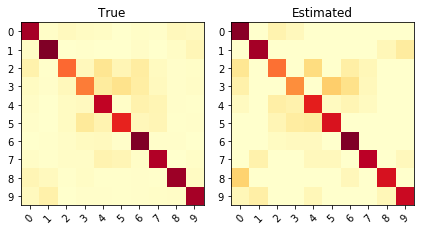

JS divergence: 0.0658	Norm Frobenius: 0.0407


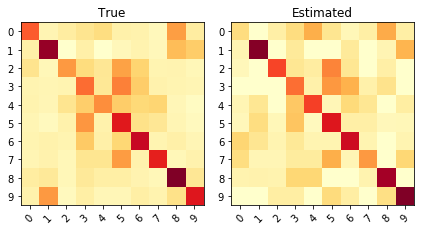

JS divergence: 0.0954	Norm Frobenius: 0.0617
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global      0.7416        0.7416     0.0637944  0.0947563      0.0636654   0.0943882
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7104        0.7104
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


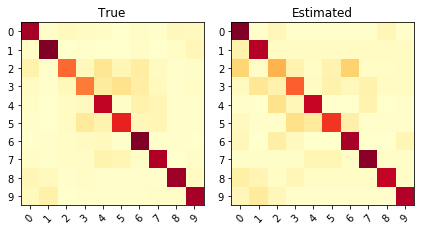

JS divergence: 0.0804	Norm Frobenius: 0.0797


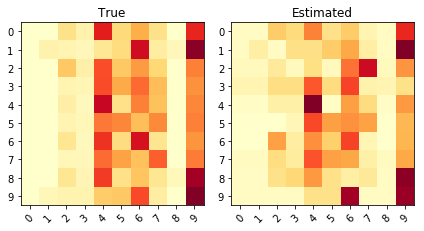

JS divergence: 0.0790	Norm Frobenius: 0.0547


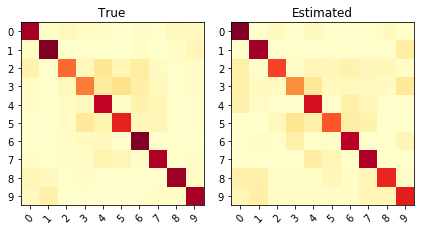

JS divergence: 0.0571	Norm Frobenius: 0.0652


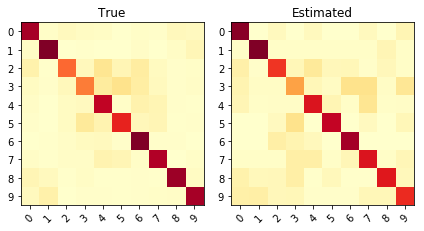

JS divergence: 0.0827	Norm Frobenius: 0.0806


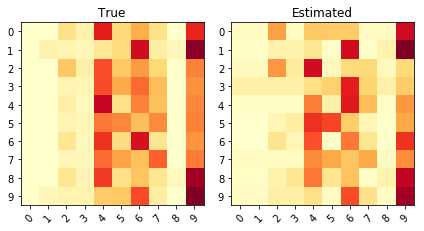

JS divergence: 0.0738	Norm Frobenius: 0.0501


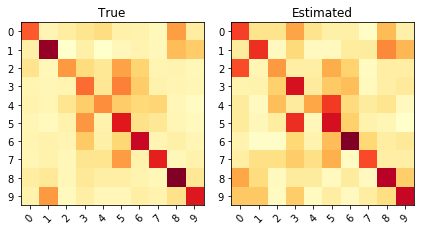

JS divergence: 0.0412	Norm Frobenius: 0.0551


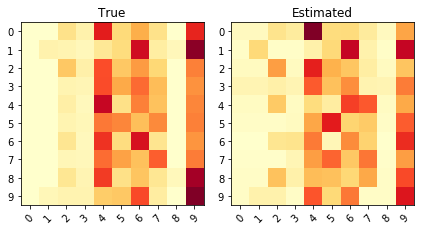

JS divergence: 0.0686	Norm Frobenius: 0.0541


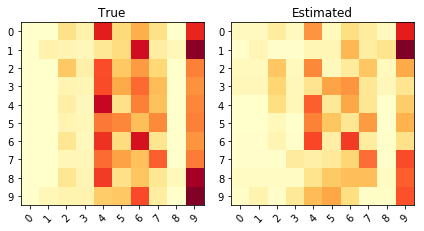

JS divergence: 0.0776	Norm Frobenius: 0.0551


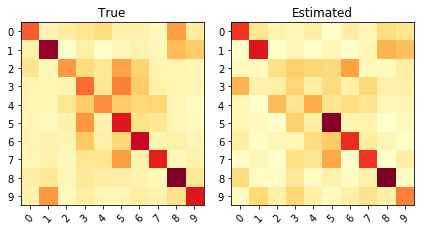

JS divergence: 0.0455	Norm Frobenius: 0.0522


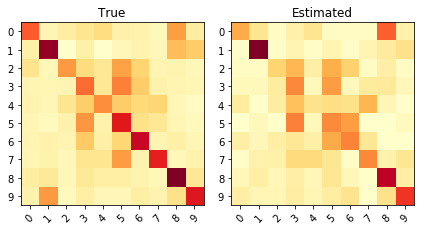

JS divergence: 0.0426	Norm Frobenius: 0.0517


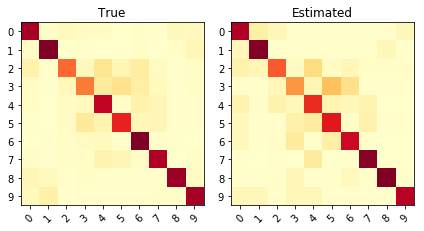

JS divergence: 0.0682	Norm Frobenius: 0.0724


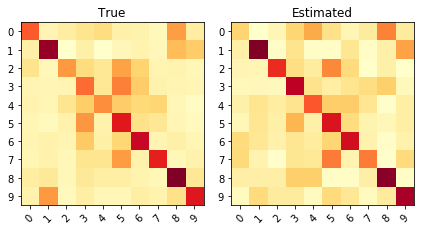

JS divergence: 0.0450	Norm Frobenius: 0.0524


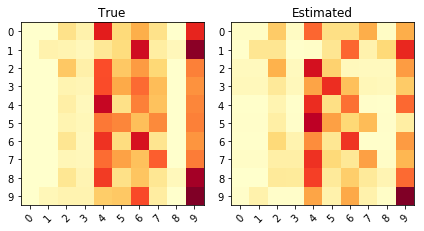

JS divergence: 0.0778	Norm Frobenius: 0.0528


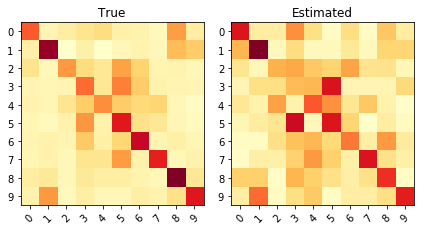

JS divergence: 0.0537	Norm Frobenius: 0.0630


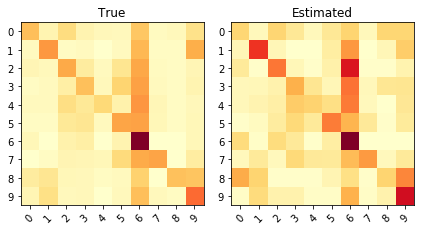

JS divergence: 0.0574	Norm Frobenius: 0.0563
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global     0.81238       0.81238      0.058832  0.0577144      0.0587424   0.0575948     0.160605      0.160411
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.417654      

In [24]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


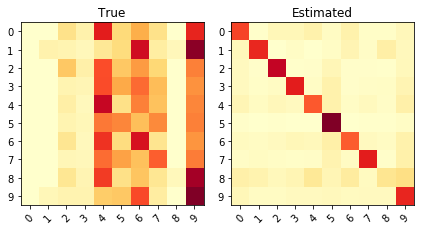

JS divergence: 0.3463	Norm Frobenius: 0.1932


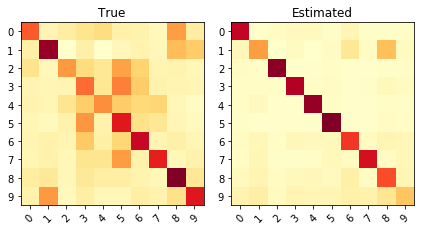

JS divergence: 0.1754	Norm Frobenius: 0.1492


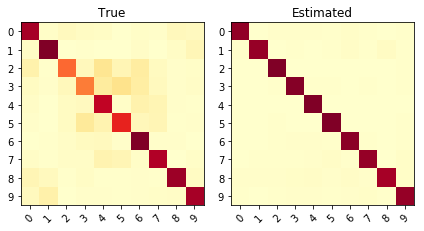

JS divergence: 0.0924	Norm Frobenius: 0.0899


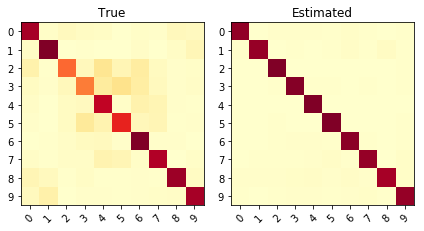

JS divergence: 0.0924	Norm Frobenius: 0.0899


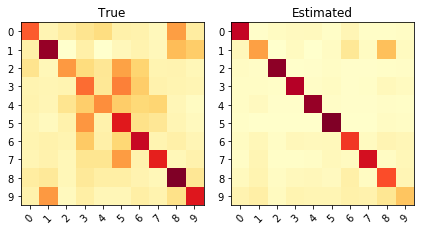

JS divergence: 0.1755	Norm Frobenius: 0.1492


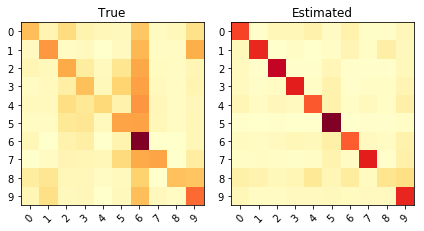

JS divergence: 0.1980	Norm Frobenius: 0.1525


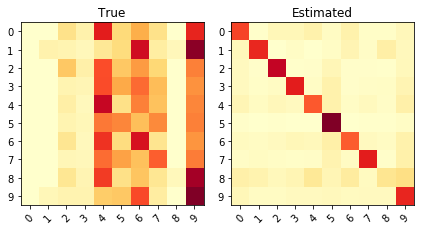

JS divergence: 0.3463	Norm Frobenius: 0.1932


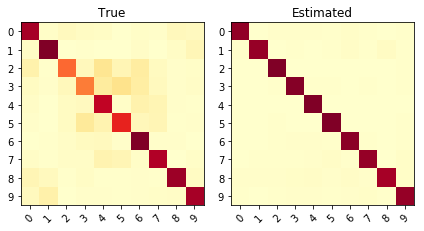

JS divergence: 0.0924	Norm Frobenius: 0.0899


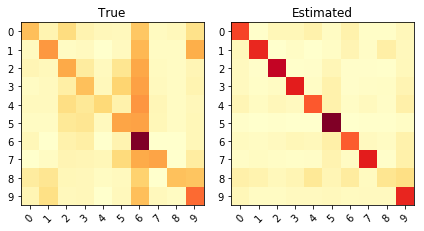

JS divergence: 0.1980	Norm Frobenius: 0.1525


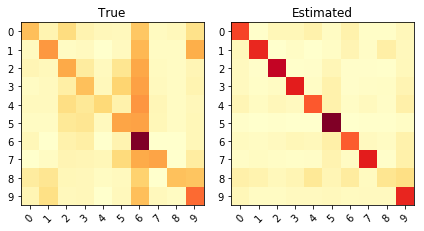

JS divergence: 0.1980	Norm Frobenius: 0.1525


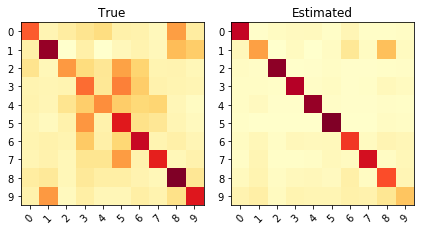

JS divergence: 0.1755	Norm Frobenius: 0.1492


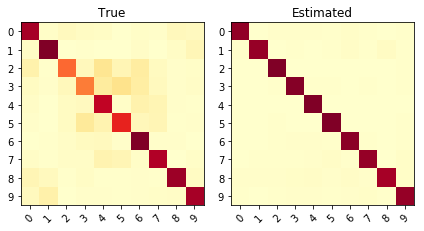

JS divergence: 0.0924	Norm Frobenius: 0.0899


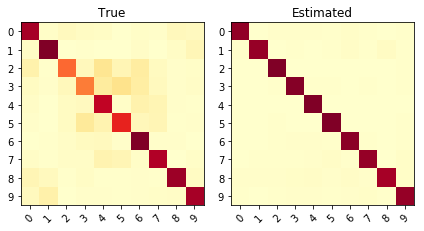

JS divergence: 0.0924	Norm Frobenius: 0.0899


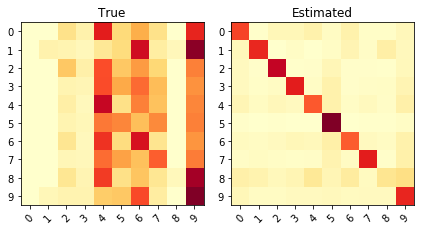

JS divergence: 0.3463	Norm Frobenius: 0.1932


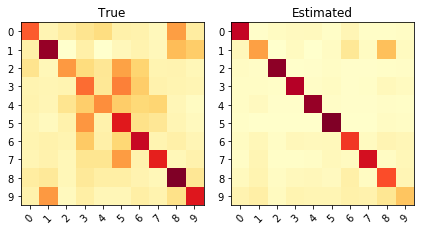

JS divergence: 0.1755	Norm Frobenius: 0.1492
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global      0.7924        0.7924       0.14541     0.1944       0.145409    0.194445     0.388367      0.388112
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.382867      

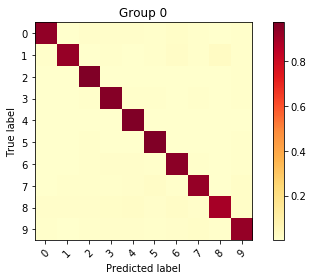

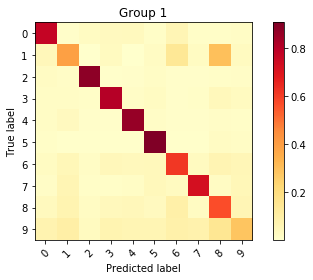

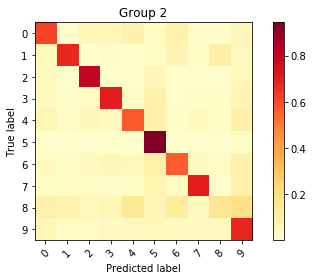

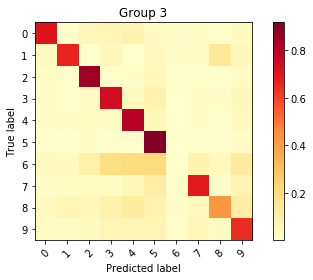

Inertia: 0.10046657532255826
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.334409     668    0.32546     0.944208  0.0577276       0.958766   0.938009      0.7221        0.7221
   1         1  0.148858     297    1.16679     0.680766  0.441256        0.716506   0.645295      0.7445        0.7445
   2         2  0.337343     674    1.28162     0.642341  0.519331        0.676595   0.602601      0.6555        0.6555
   3         3  0.17939      358    1.1908      0.646327  0.998803        0.644329   0.60703       0.6819        0.6819
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A

In [27]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T$ = 10000, $T_{max}$ = 40 )

In [17]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.85384


*** Soft-Majority (Train with softMV) ***
Train


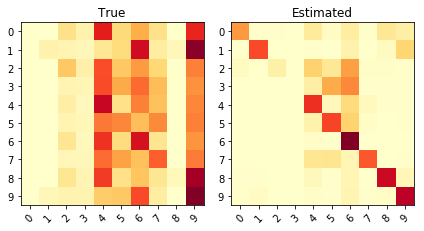

JS divergence: 0.3143	Norm Frobenius: 0.1795


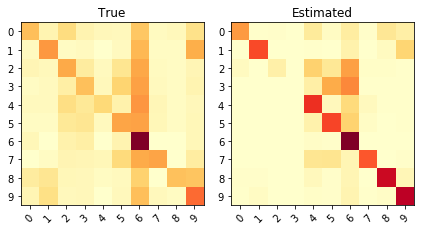

JS divergence: 0.2056	Norm Frobenius: 0.1331


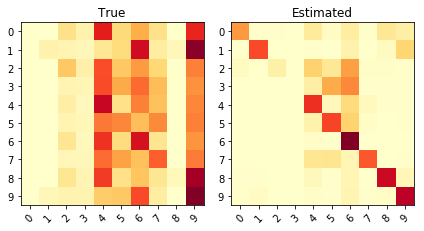

JS divergence: 0.3143	Norm Frobenius: 0.1795


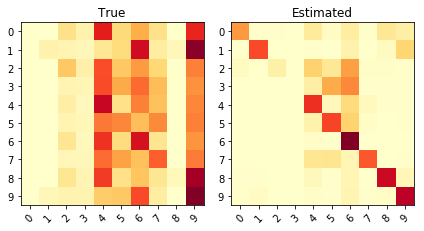

JS divergence: 0.3143	Norm Frobenius: 0.1795


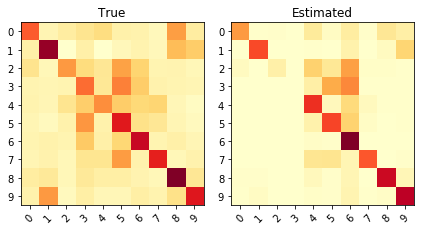

JS divergence: 0.2091	Norm Frobenius: 0.1290


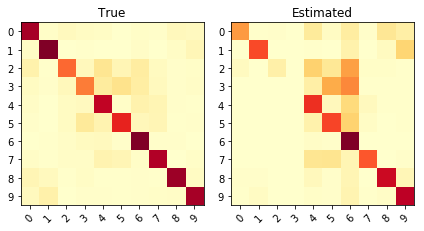

JS divergence: 0.1375	Norm Frobenius: 0.1101


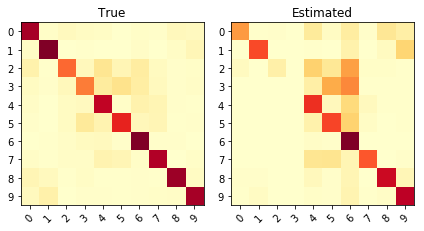

JS divergence: 0.1375	Norm Frobenius: 0.1101


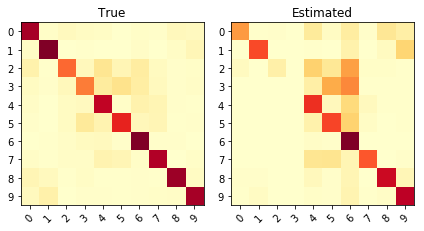

JS divergence: 0.1375	Norm Frobenius: 0.1101


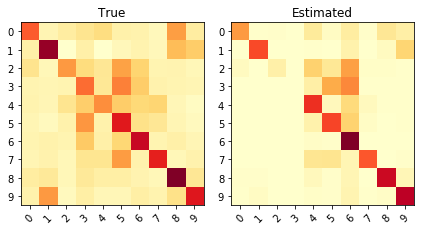

JS divergence: 0.2091	Norm Frobenius: 0.1290


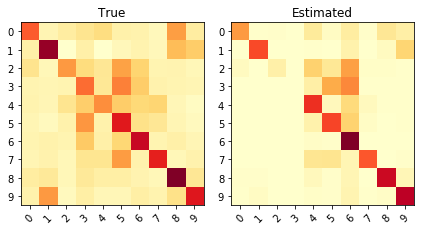

JS divergence: 0.2091	Norm Frobenius: 0.1290


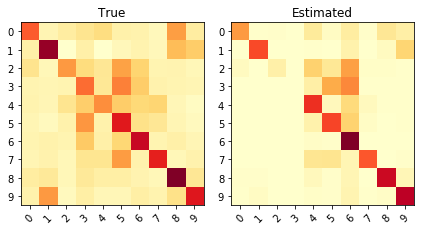

JS divergence: 0.2091	Norm Frobenius: 0.1290


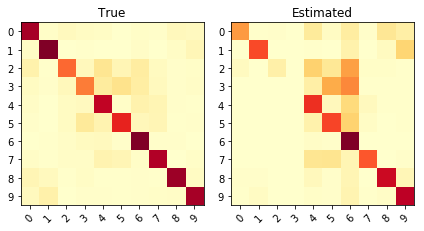

JS divergence: 0.1375	Norm Frobenius: 0.1101


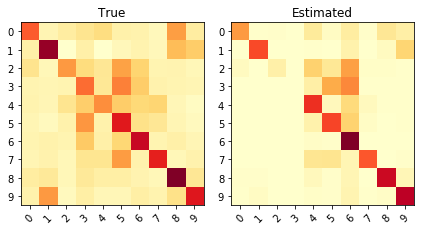

JS divergence: 0.2091	Norm Frobenius: 0.1290


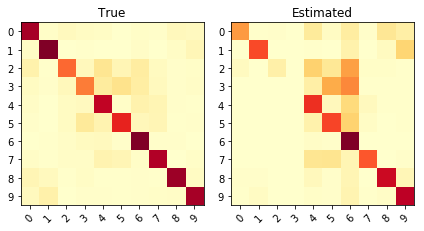

JS divergence: 0.1375	Norm Frobenius: 0.1101


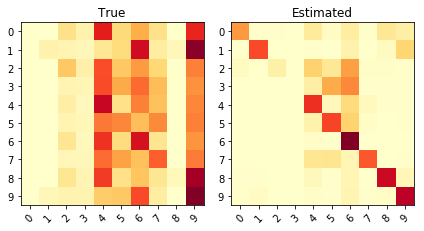

JS divergence: 0.3143	Norm Frobenius: 0.1795
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.56636       0.56636      0.136273   0.216035       0.136275    0.216048
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.5566        0.5566
====  ======  ==========  ============


In [18]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


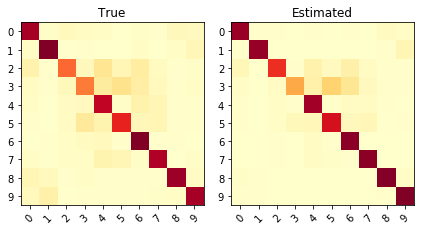

JS divergence: 0.0271	Norm Frobenius: 0.0435


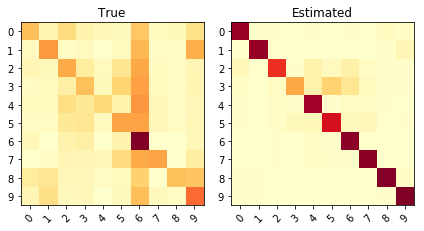

JS divergence: 0.2954	Norm Frobenius: 0.1958


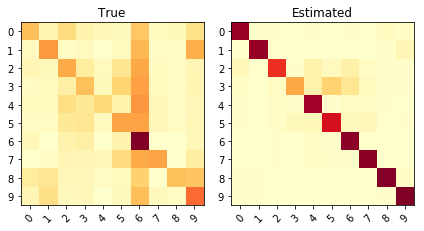

JS divergence: 0.2954	Norm Frobenius: 0.1958


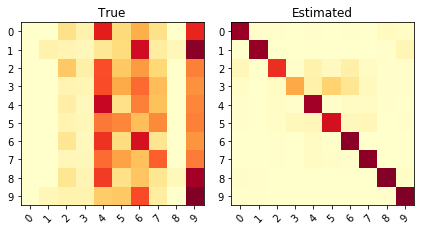

JS divergence: 0.4888	Norm Frobenius: 0.2473


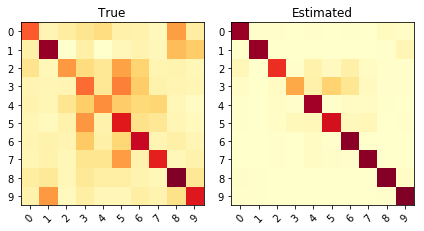

JS divergence: 0.2413	Norm Frobenius: 0.1719


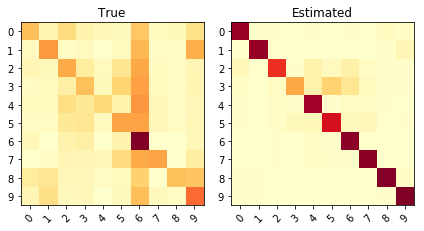

JS divergence: 0.2954	Norm Frobenius: 0.1958


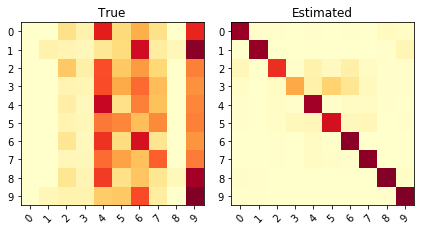

JS divergence: 0.4888	Norm Frobenius: 0.2473


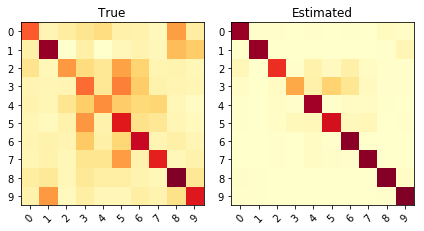

JS divergence: 0.2413	Norm Frobenius: 0.1719


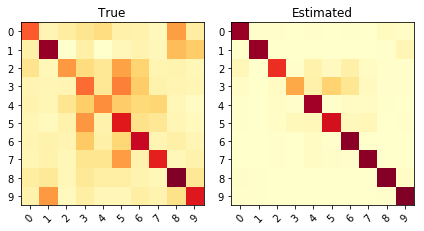

JS divergence: 0.2413	Norm Frobenius: 0.1719


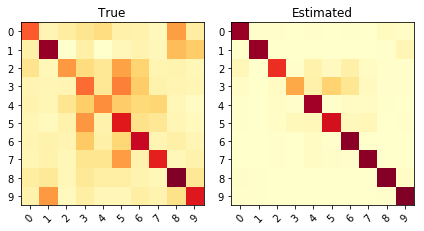

JS divergence: 0.2413	Norm Frobenius: 0.1719


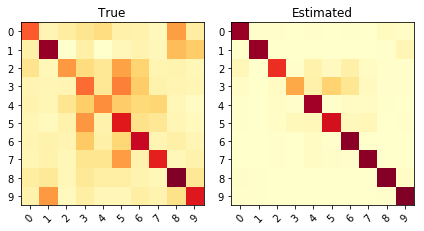

JS divergence: 0.2413	Norm Frobenius: 0.1719


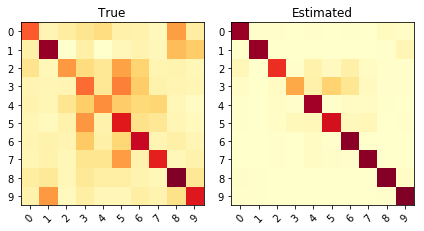

JS divergence: 0.2413	Norm Frobenius: 0.1719


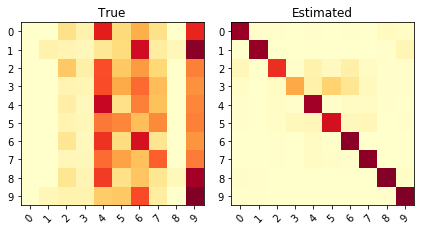

JS divergence: 0.4888	Norm Frobenius: 0.2473


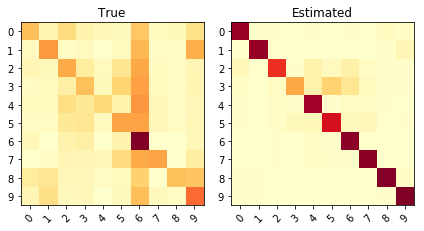

JS divergence: 0.2954	Norm Frobenius: 0.1958


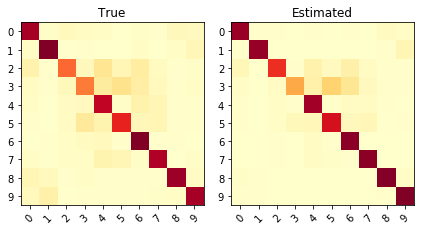

JS divergence: 0.0271	Norm Frobenius: 0.0435
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.83816       0.83816      0.165653   0.257987       0.165688    0.258037
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7756        0.7756
====  ======  ==========  ============


In [20]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


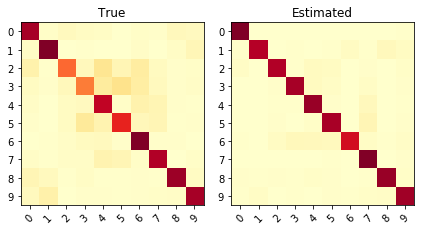

JS divergence: 0.0740	Norm Frobenius: 0.0788


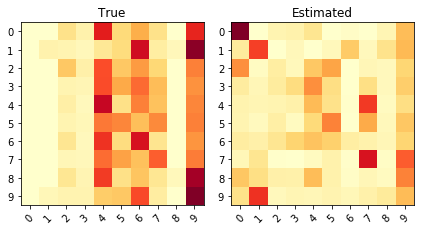

JS divergence: 0.2606	Norm Frobenius: 0.1239


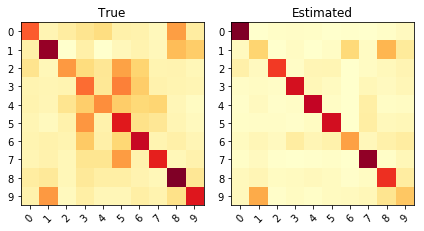

JS divergence: 0.1627	Norm Frobenius: 0.1363


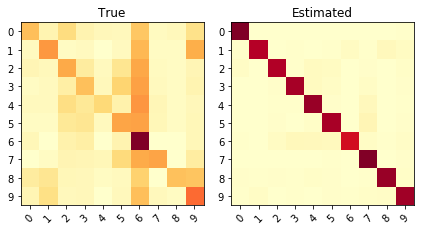

JS divergence: 0.3629	Norm Frobenius: 0.2183


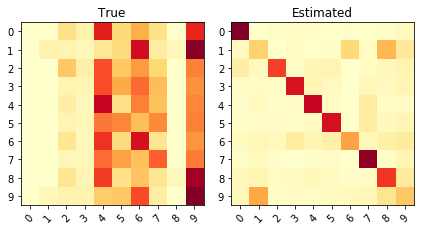

JS divergence: 0.3982	Norm Frobenius: 0.1975


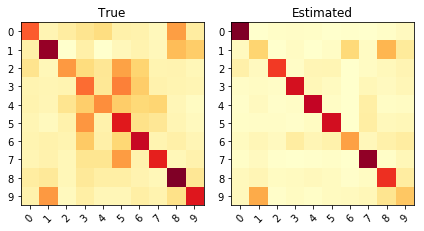

JS divergence: 0.1627	Norm Frobenius: 0.1363


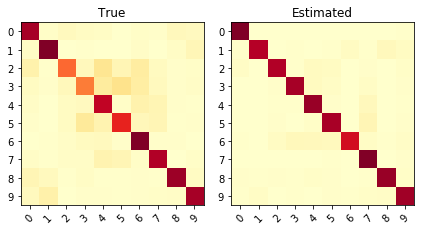

JS divergence: 0.0740	Norm Frobenius: 0.0788


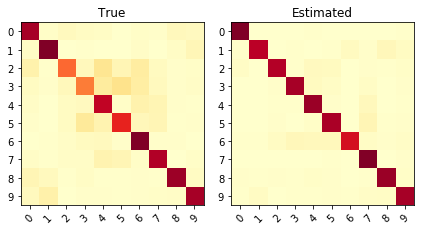

JS divergence: 0.0725	Norm Frobenius: 0.0779


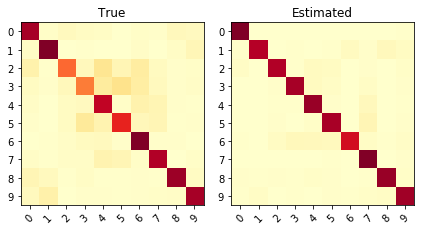

JS divergence: 0.0739	Norm Frobenius: 0.0788


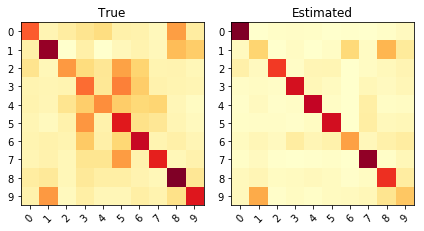

JS divergence: 0.1627	Norm Frobenius: 0.1363


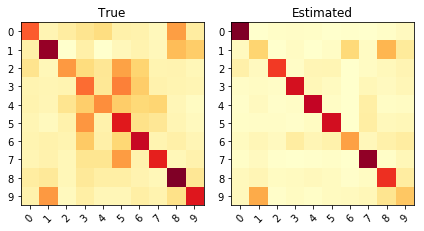

JS divergence: 0.1626	Norm Frobenius: 0.1363


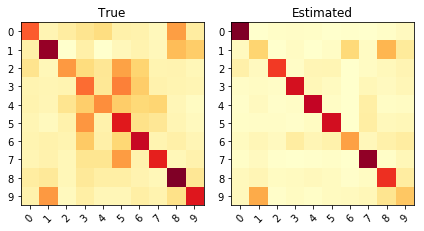

JS divergence: 0.1627	Norm Frobenius: 0.1363


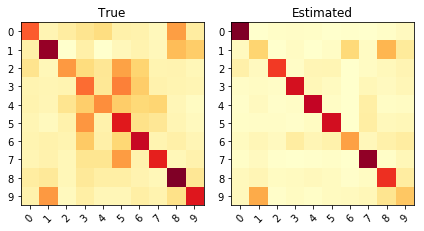

JS divergence: 0.1627	Norm Frobenius: 0.1363


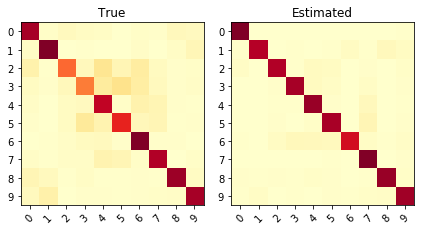

JS divergence: 0.0740	Norm Frobenius: 0.0788


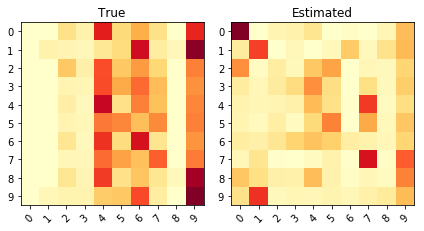

JS divergence: 0.2606	Norm Frobenius: 0.1239
A result
 ====  ======  ==========  ============  ============  =========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS
====  ======  ==========  ============  ============  =========
   0  Global     0.76614       0.76614       0.13475   0.194368
====  ======  ==========  ============  ============  =========
Test


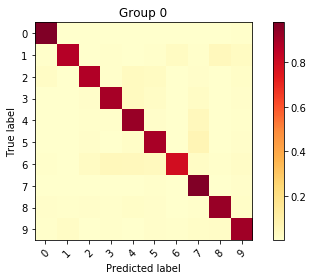

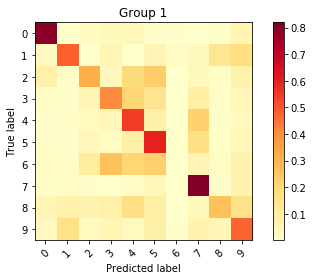

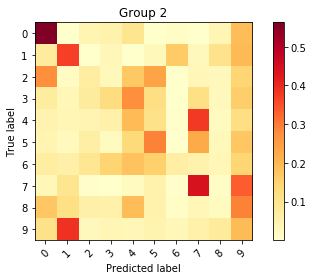

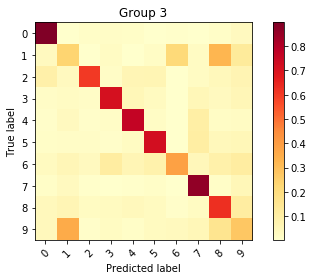

Inertia: 0.1914079067547104
A result
 ====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.508636   0.462616     0.905938   0.100453       0.928919   0.895487      0.7343        0.7343
   1         1  0.122513   1.4994       0.47179    1.3268         0.457432   0.4131        0.6136        0.6136
   2         2  0.237695   1.80251      0.233489   1.83309        0.124393   0.148321      0.391         0.391
   3         3  0.131156   1.26102      0.609469   0.582949       0.637801   0.566077      0.6302        0.6302
====  ========  ========  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Ac

In [26]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 + bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

#### 7) configuration: Manny annot v1 + soft ($T$ = 2000, $T_{max}$ = 20 )

*** Soft-Majority (Train with softMV) ***
Train


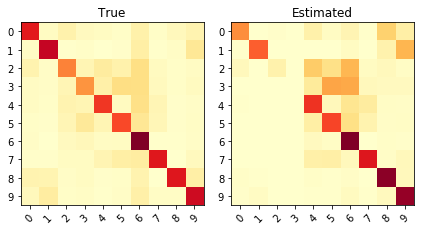

JS divergence: 0.1150	Norm Frobenius: 0.0894


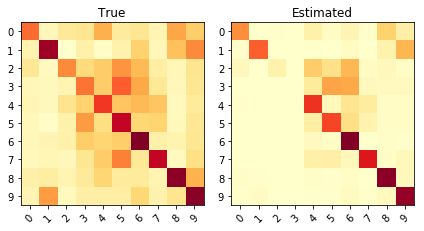

JS divergence: 0.1811	Norm Frobenius: 0.1296


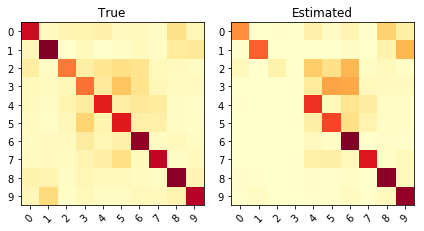

JS divergence: 0.1239	Norm Frobenius: 0.0929


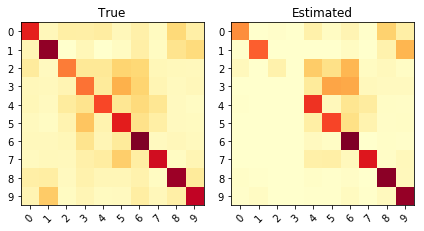

JS divergence: 0.1383	Norm Frobenius: 0.1009


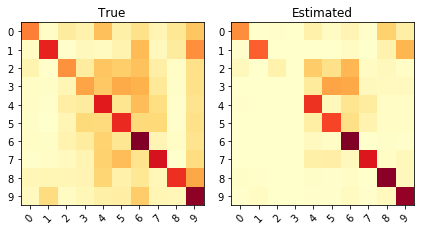

JS divergence: 0.1619	Norm Frobenius: 0.1213


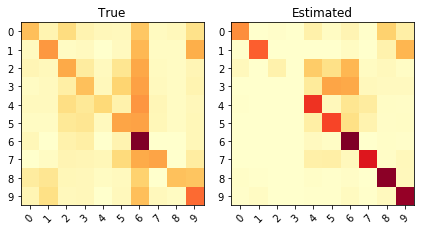

JS divergence: 0.2254	Norm Frobenius: 0.1420


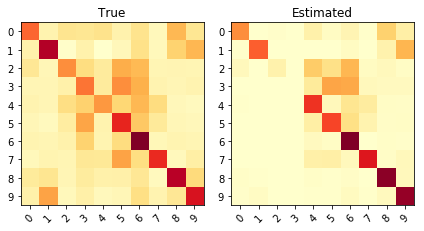

JS divergence: 0.1792	Norm Frobenius: 0.1240


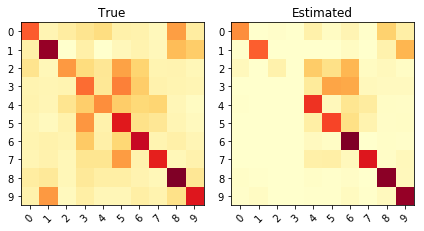

JS divergence: 0.1837	Norm Frobenius: 0.1255


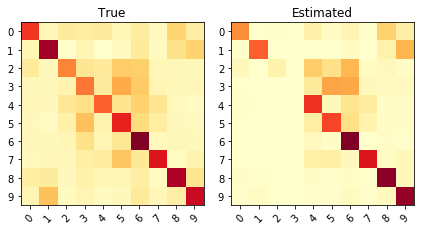

JS divergence: 0.1482	Norm Frobenius: 0.1066


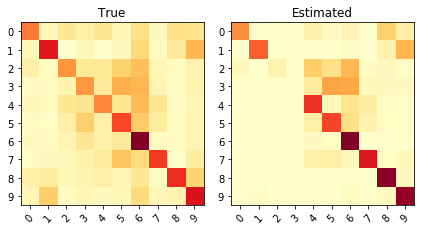

JS divergence: 0.1604	Norm Frobenius: 0.1165


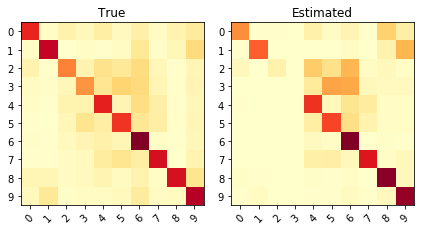

JS divergence: 0.1142	Norm Frobenius: 0.0899


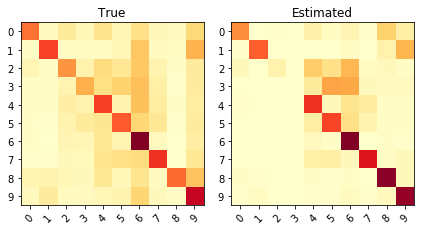

JS divergence: 0.1454	Norm Frobenius: 0.1078


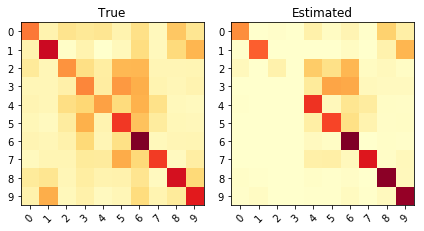

JS divergence: 0.1799	Norm Frobenius: 0.1244


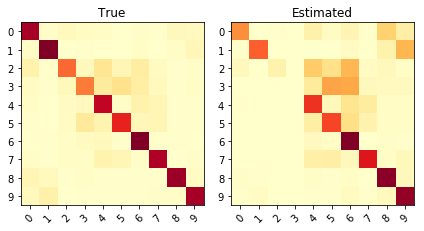

JS divergence: 0.1215	Norm Frobenius: 0.1049


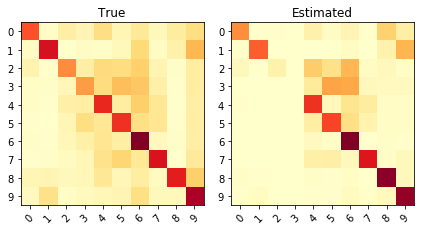

JS divergence: 0.1379	Norm Frobenius: 0.1055
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.57298       0.57298      0.116418   0.161407       0.116393    0.161366
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.5648        0.5648
====  ======  ==========  ============


In [16]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


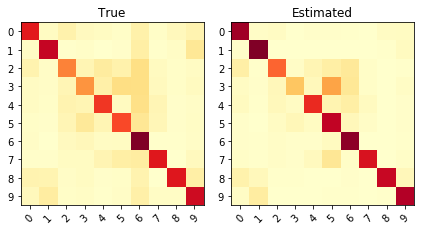

JS divergence: 0.0511	Norm Frobenius: 0.0663


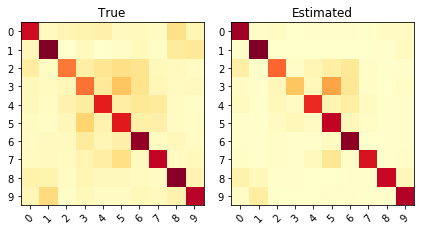

JS divergence: 0.0683	Norm Frobenius: 0.0787


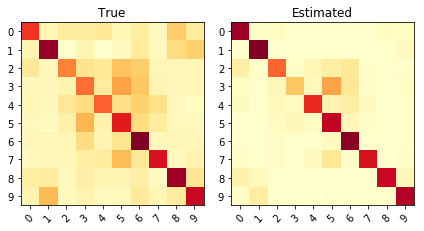

JS divergence: 0.1278	Norm Frobenius: 0.1206


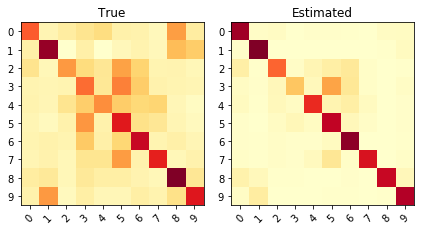

JS divergence: 0.1668	Norm Frobenius: 0.1416


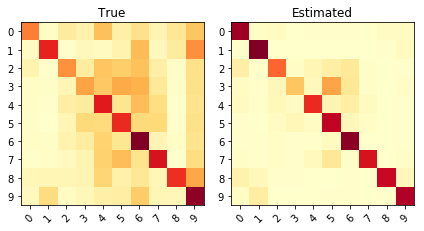

JS divergence: 0.1942	Norm Frobenius: 0.1500


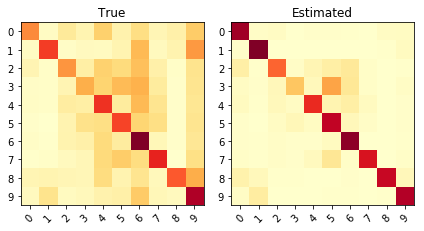

JS divergence: 0.1874	Norm Frobenius: 0.1474


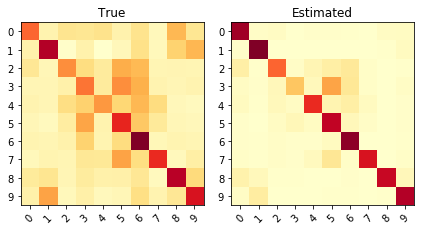

JS divergence: 0.1686	Norm Frobenius: 0.1431


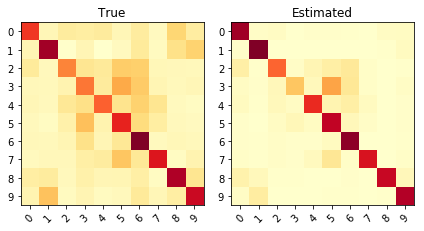

JS divergence: 0.1211	Norm Frobenius: 0.1167


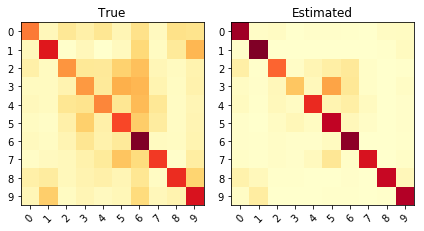

JS divergence: 0.1589	Norm Frobenius: 0.1375


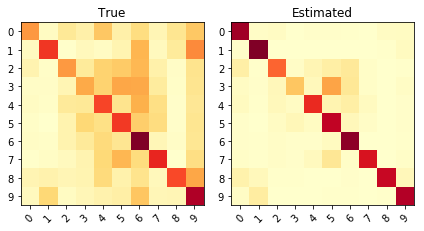

JS divergence: 0.2051	Norm Frobenius: 0.1566


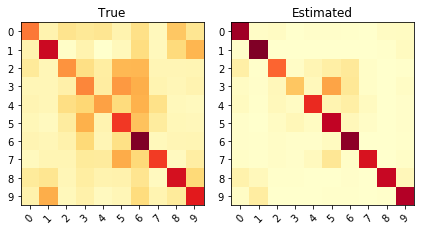

JS divergence: 0.1706	Norm Frobenius: 0.1444


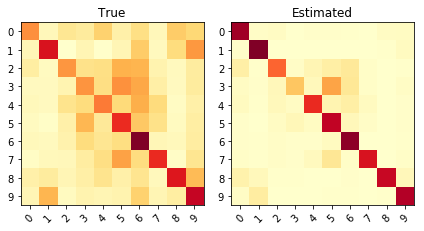

JS divergence: 0.1980	Norm Frobenius: 0.1553


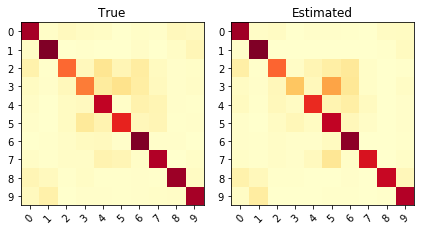

JS divergence: 0.0251	Norm Frobenius: 0.0428


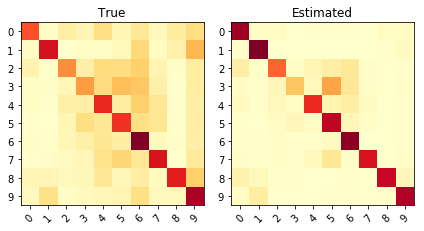

JS divergence: 0.1444	Norm Frobenius: 0.1257


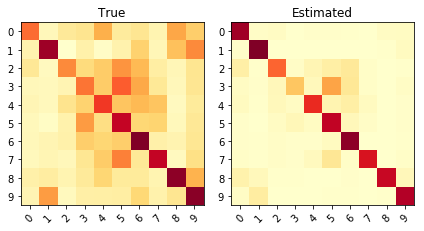

JS divergence: 0.2029	Norm Frobenius: 0.1562
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global     0.74234       0.74234        0.1325    0.16034       0.132448    0.160215
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7069        0.7069
====  ======  ==========  ============


In [18]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


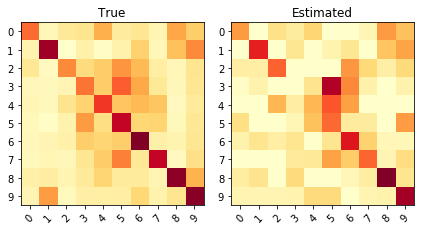

JS divergence: 0.1354	Norm Frobenius: 0.0742


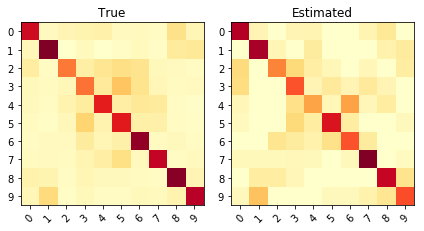

JS divergence: 0.1097	Norm Frobenius: 0.0643


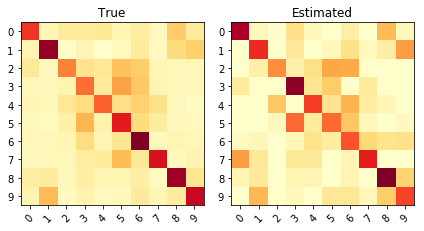

JS divergence: 0.1144	Norm Frobenius: 0.0694


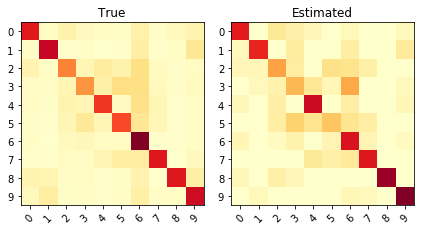

JS divergence: 0.0895	Norm Frobenius: 0.0626


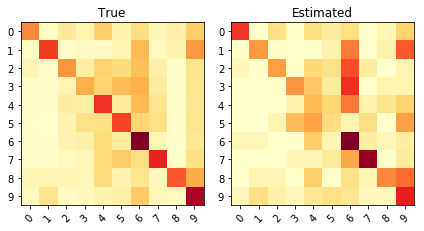

JS divergence: 0.0861	Norm Frobenius: 0.0656


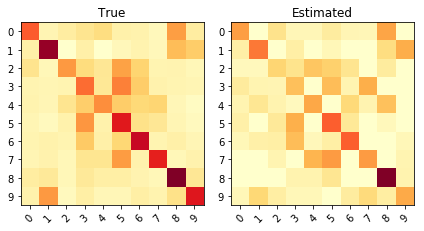

JS divergence: 0.1131	Norm Frobenius: 0.0657


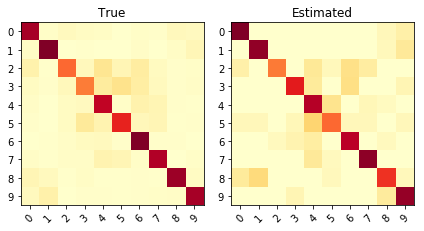

JS divergence: 0.0876	Norm Frobenius: 0.0572


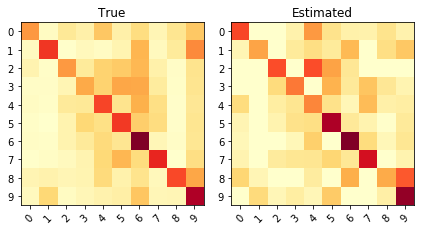

JS divergence: 0.1143	Norm Frobenius: 0.0686


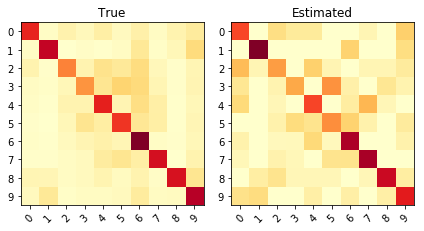

JS divergence: 0.1119	Norm Frobenius: 0.0605


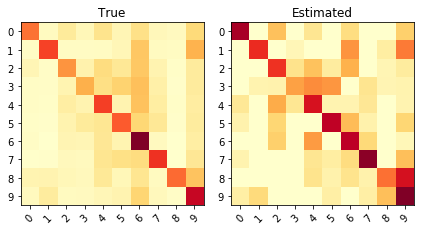

JS divergence: 0.1154	Norm Frobenius: 0.0658


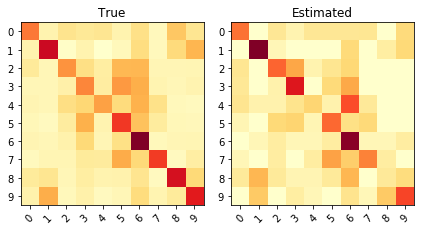

JS divergence: 0.1004	Norm Frobenius: 0.0678


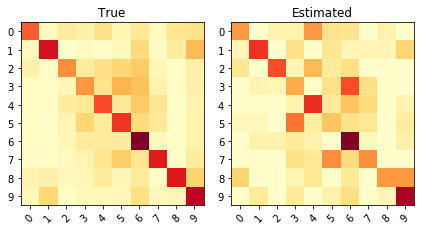

JS divergence: 0.1052	Norm Frobenius: 0.0672


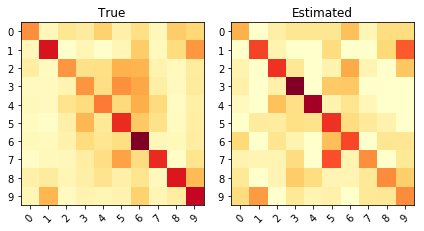

JS divergence: 0.1186	Norm Frobenius: 0.0742


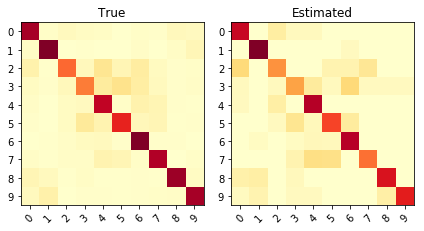

JS divergence: 0.0793	Norm Frobenius: 0.0552


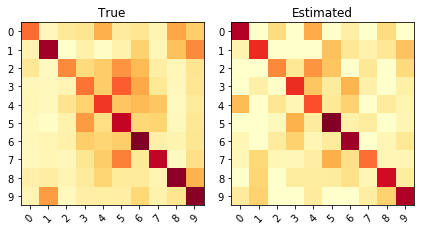

JS divergence: 0.1087	Norm Frobenius: 0.0677
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global      0.7367        0.7367     0.0673977   0.108685      0.0672591    0.108289
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7085        0.7085
====  ======  ==========  ============


In [20]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


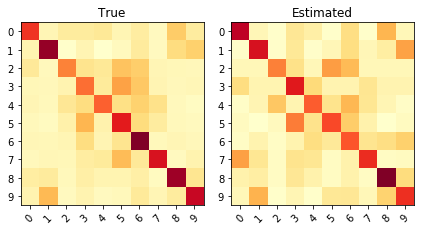

JS divergence: 0.0505	Norm Frobenius: 0.0591


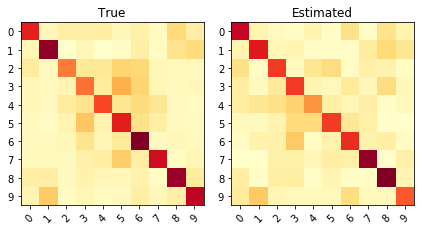

JS divergence: 0.0485	Norm Frobenius: 0.0552


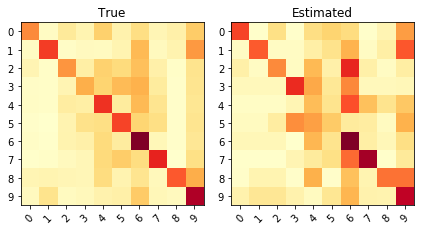

JS divergence: 0.0415	Norm Frobenius: 0.0546


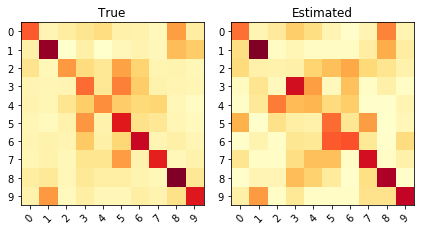

JS divergence: 0.0617	Norm Frobenius: 0.0629


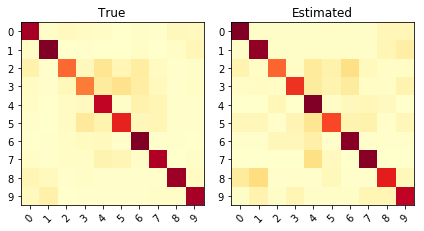

JS divergence: 0.0650	Norm Frobenius: 0.0740


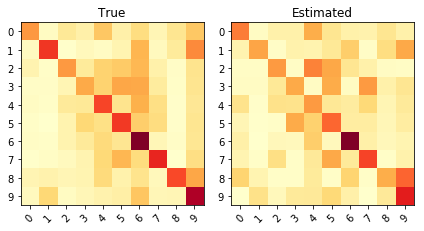

JS divergence: 0.0485	Norm Frobenius: 0.0516


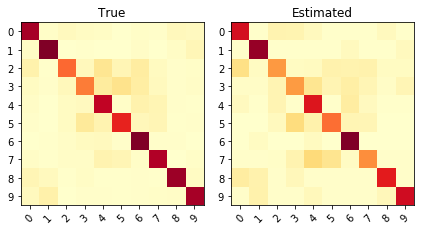

JS divergence: 0.0654	Norm Frobenius: 0.0777


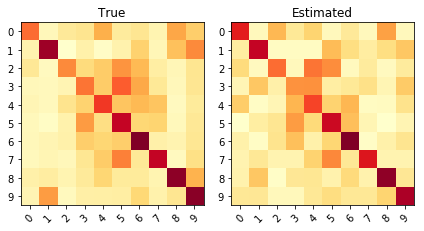

JS divergence: 0.0411	Norm Frobenius: 0.0456


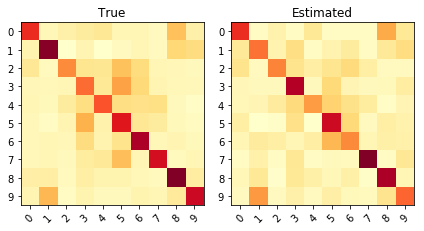

JS divergence: 0.0452	Norm Frobenius: 0.0589


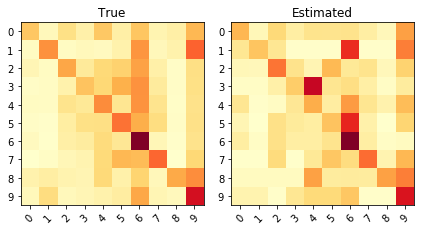

JS divergence: 0.0459	Norm Frobenius: 0.0526


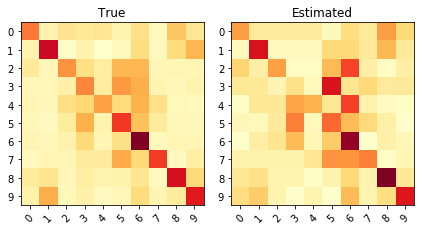

JS divergence: 0.0393	Norm Frobenius: 0.0503


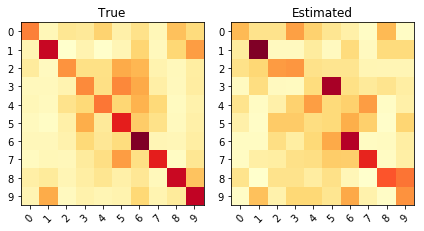

JS divergence: 0.0534	Norm Frobenius: 0.0603


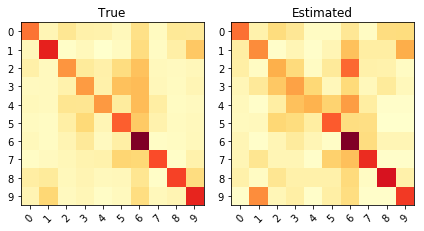

JS divergence: 0.0479	Norm Frobenius: 0.0557


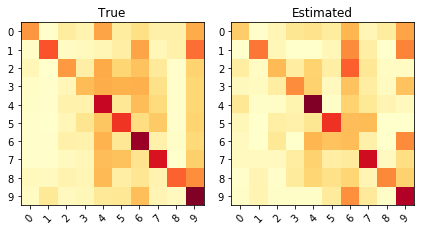

JS divergence: 0.0521	Norm Frobenius: 0.0547


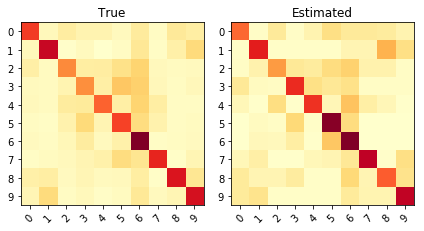

JS divergence: 0.0411	Norm Frobenius: 0.0524
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global     0.78822       0.78822     0.0559301  0.0476616      0.0558411   0.0475231     0.248172      0.248423
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.376684      

In [23]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


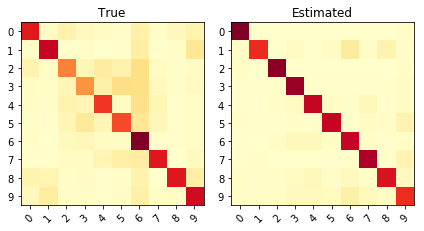

JS divergence: 0.1222	Norm Frobenius: 0.1049


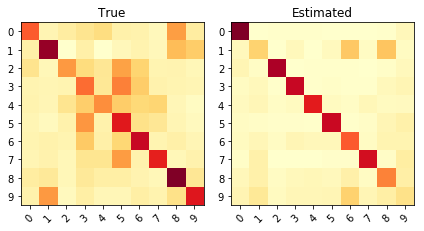

JS divergence: 0.1936	Norm Frobenius: 0.1453


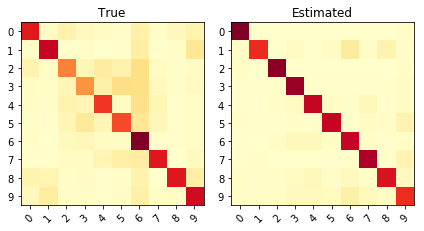

JS divergence: 0.1222	Norm Frobenius: 0.1049


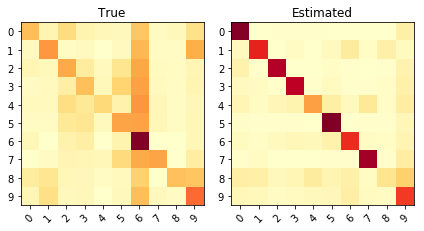

JS divergence: 0.2286	Norm Frobenius: 0.1603


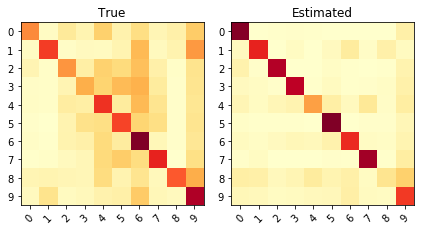

JS divergence: 0.1823	Norm Frobenius: 0.1426


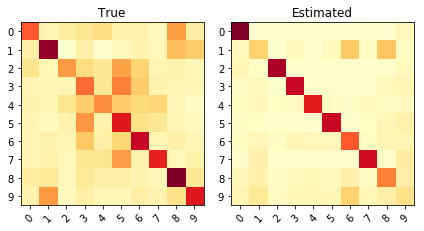

JS divergence: 0.1933	Norm Frobenius: 0.1453


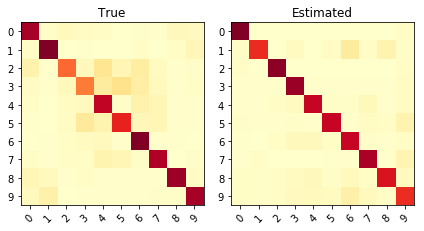

JS divergence: 0.0946	Norm Frobenius: 0.0824


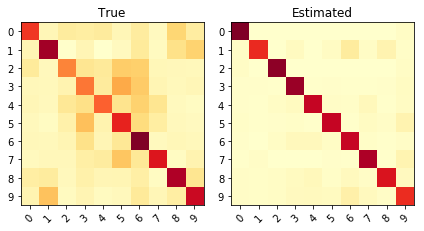

JS divergence: 0.1941	Norm Frobenius: 0.1500


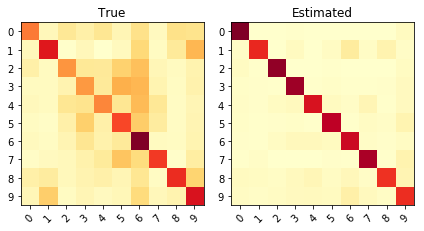

JS divergence: 0.2080	Norm Frobenius: 0.1604


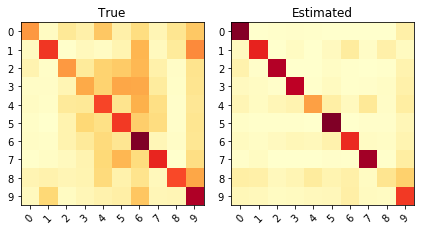

JS divergence: 0.1944	Norm Frobenius: 0.1500


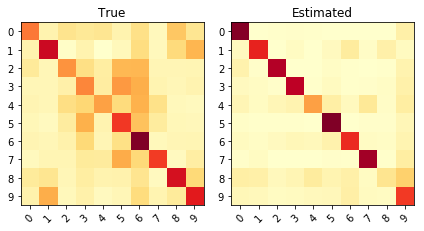

JS divergence: 0.1904	Norm Frobenius: 0.1451


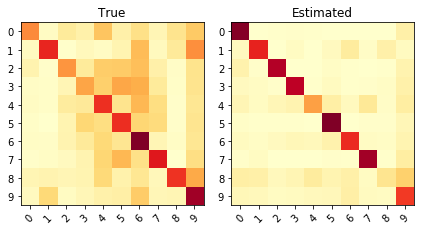

JS divergence: 0.1880	Norm Frobenius: 0.1469


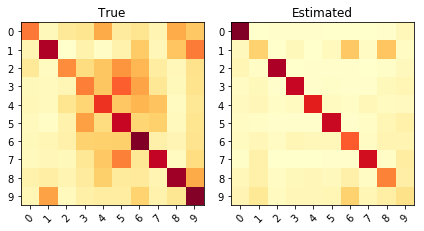

JS divergence: 0.2061	Norm Frobenius: 0.1524


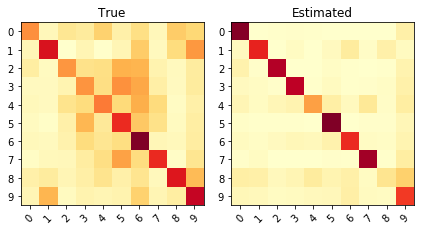

JS divergence: 0.1956	Norm Frobenius: 0.1509


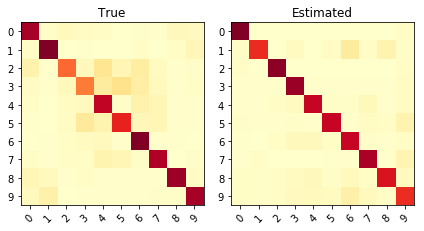

JS divergence: 0.0946	Norm Frobenius: 0.0824
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global       0.809         0.809       0.14463   0.187619       0.144616     0.18758     0.384968       0.38485
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.379799      

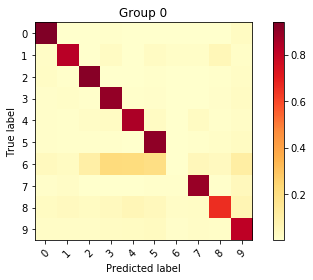

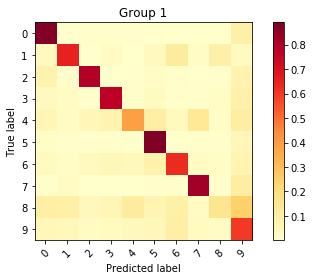

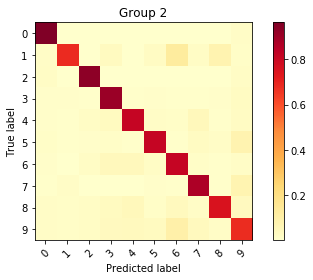

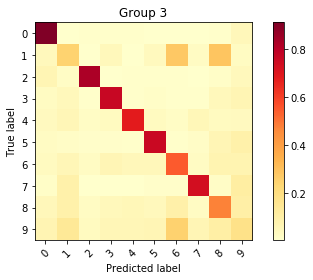

Inertia: 0.08145715914855521
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.158651     317   0.80561      0.771586   0.753001       0.757401   0.746207      0.6839        0.6839
   1         1  0.334346     668   1.17471      0.658741   0.513448       0.685563   0.620823      0.6248        0.6248
   2         2  0.349622     699   0.766221     0.823555   0.20069        0.860772   0.80395       0.7479        0.7479
   3         3  0.157381     314   1.27153      0.612435   0.599739       0.635352   0.569372      0.5971        0.5971
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A

In [26]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### Test annotations CIFAR
---
try to find groups...

In [5]:
from scipy.io import loadmat
from code.utils import *
from code.representation import *
from code.evaluation import Evaluation_metrics
from code.baseline import *


#change sets
aux1 = Xstd_train.copy()
aux2 = Z_train.copy()
Xstd_train = Xstd_test.copy()
Z_train = Z_test.copy()
Xstd_test = aux1[:10000]
Z_test = aux2[:10000]

N = Xstd_train.shape[0]

In [6]:
folder = "../New_CIFAR_test/"

aux = loadmat(folder+"CIFAR10_HumanRecogData.mat")
aux = aux["expData"][0][0][0]
T = 60
y_obs = np.ones((N,T),dtype='int16')*-1
for annotation in aux:
    ann_id = annotation[0]-1
    cifar_indx = annotation[1]-1
    ann = annotation[2]-1
    y_obs[cifar_indx,ann_id] = ann

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (10000, 60, 10)


In [18]:
#train with mv...
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_soft = label_I.mv_labels('probas')
print("ACC MV on train:",np.mean(mv_soft.argmax(axis=1)==Z_train))

ACC MV on train: 0.9757


In [ ]:
JS or norm of raykar?? as a reference...

In [28]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs,"repeat")

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

vector of repeats:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 5 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 0 ... 6 0 0]]
shape: (10000, 10)
Normalized entropy (0-1) of repeats annotations: 0.05247443779676492


In [29]:
M_seted = 4 #to find anything that is...

In [42]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
#gMixture_Global.define_model("default cnn")
gMixture_Global.define_model("simple cnn",32,2,double=True,BatchN=True,drop=0.25)

gMixture_Global.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True) #more?

Needed params (units,deep,drop,double?,BatchN?)
Doing clustering...Done!
Get init alphas in 0.062321 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85106486 0.04307195 0.08809585 0.25337324]
Alphas:  (4,)
MV init:  (10000, 10)
Betas:  (4, 10, 10)
Q estimate:  (10000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 9.44 sec)	logL: -95797.864	
Iter 2/50
M step: done,  E step: done //  (in 3.69 sec)	logL: -79553.930	Tol1: 0.16956	Tol2: 1.09479	Tol3: 0.84191	
Iter 3/50
M step: done,  E step: done //  (in 3.59 sec)	logL: -68442.405	Tol1: 0.13967	Tol2: 0.42932	Tol3: 0.07833	
Iter 4/50
M step: done,  E step: done //  (in 3.40 sec)	logL: -60706.463	Tol1: 0.11303	Tol2: 0.25864	Tol3: 0.05677	
Iter 5/50
M step: done,  E step: done //  (in 3.38 sec)	logL: -49984.022	Tol1: 0.17663	Tol2: 0.18036	Tol3: 0.12539	
Iter 6/50
M step: done,  E step: done //  (in 3.49 sec)	logL: -51167.608	Tol1: 0.02368	Tol2: 0.28393	Tol3: 0.16128	
Iter 7/50
M step: done,  E

M step: done,  E step: done //  (in 3.27 sec)	logL: -15068.961	Tol1: 0.10455	Tol2: 0.04736	Tol3: 0.03901	
Iter 28/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -15601.802	Tol1: 0.03536	Tol2: 0.03874	Tol3: 0.06074	
Iter 29/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -15881.325	Tol1: 0.01792	Tol2: 0.04685	Tol3: 0.02642	
Iter 30/50
M step: done,  E step: done //  (in 3.30 sec)	logL: -14796.265	Tol1: 0.06832	Tol2: 0.03184	Tol3: 0.02539	
Iter 31/50
M step: done,  E step: done //  (in 3.26 sec)	logL: -14046.410	Tol1: 0.05068	Tol2: 0.04499	Tol3: 0.02145	
Iter 32/50
M step: done,  E step: done //  (in 3.30 sec)	logL: -15040.549	Tol1: 0.07078	Tol2: 0.03659	Tol3: 0.05519	
Iter 33/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -13988.797	Tol1: 0.06993	Tol2: 0.04931	Tol3: 0.01120	
Iter 34/50
M step: done,  E step: done //  (in 3.26 sec)	logL: -14100.556	Tol1: 0.00799	Tol2: 0.03300	Tol3: 0.05224	
Iter 35/50
M step: done,  E step: done //  (in 3.34 sec)	logL: -14032.696	T

M step: done,  E step: done //  (in 3.26 sec)	logL: -29588.888	Tol1: 0.12094	Tol2: 0.16672	Tol3: 0.16666	
Iter 14/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -28520.425	Tol1: 0.03611	Tol2: 0.11464	Tol3: 0.19471	
Iter 15/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -29208.280	Tol1: 0.02412	Tol2: 0.09380	Tol3: 0.14486	
Iter 16/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -30293.235	Tol1: 0.03715	Tol2: 0.09962	Tol3: 0.18557	
Iter 17/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -28799.006	Tol1: 0.04933	Tol2: 0.12741	Tol3: 0.04159	
Iter 18/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -28661.974	Tol1: 0.00476	Tol2: 0.10035	Tol3: 0.13167	
Iter 19/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -25347.061	Tol1: 0.11566	Tol2: 0.26806	Tol3: 0.33519	
Iter 20/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -20630.409	Tol1: 0.18608	Tol2: 0.12531	Tol3: 0.22415	
Iter 21/50
M step: done,  E step: done //  (in 3.29 sec)	logL: -25628.877	T

M step: done,  E step: done //  (in 3.26 sec)	logL: -35293.800	Tol1: 0.15185	Tol2: 0.22607	Tol3: 0.16160	
Iter 11/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -39598.486	Tol1: 0.12197	Tol2: 0.18072	Tol3: 0.18737	
Iter 12/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -35518.143	Tol1: 0.10304	Tol2: 0.26217	Tol3: 0.04908	
Iter 13/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -28583.019	Tol1: 0.19526	Tol2: 0.24796	Tol3: 0.09450	
Iter 14/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -27193.005	Tol1: 0.04863	Tol2: 0.15093	Tol3: 0.18421	
Iter 15/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -24300.389	Tol1: 0.10637	Tol2: 0.10398	Tol3: 0.18456	
Iter 16/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -24759.440	Tol1: 0.01889	Tol2: 0.08397	Tol3: 0.17851	
Iter 17/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -22820.363	Tol1: 0.07832	Tol2: 0.09822	Tol3: 0.12073	
Iter 18/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -23550.890	T

M step: done,  E step: done //  (in 3.26 sec)	logL: -15397.232	Tol1: 0.04763	Tol2: 0.05428	Tol3: 0.07296	
Iter 29/50
M step: done,  E step: done //  (in 3.29 sec)	logL: -15463.853	Tol1: 0.00433	Tol2: 0.04529	Tol3: 0.05637	
Iter 30/50
M step: done,  E step: done //  (in 3.29 sec)	logL: -14890.976	Tol1: 0.03705	Tol2: 0.04295	Tol3: 0.02501	
Iter 31/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -18538.097	Tol1: 0.24492	Tol2: 0.03342	Tol3: 0.03978	
Iter 32/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -14646.693	Tol1: 0.20991	Tol2: 0.07460	Tol3: 0.00110	
Iter 33/50
M step: done,  E step: done //  (in 3.29 sec)	logL: -14636.466	Tol1: 0.00070	Tol2: 0.06760	Tol3: 0.00718	
Iter 34/50
M step: done,  E step: done //  (in 3.26 sec)	logL: -14788.836	Tol1: 0.01041	Tol2: 0.03699	Tol3: 0.01515	
Iter 35/50
M step: done,  E step: done //  (in 3.28 sec)	logL: -14368.022	Tol1: 0.02845	Tol2: 0.04722	Tol3: 0.01360	
Iter 36/50
M step: done,  E step: done //  (in 3.24 sec)	logL: -13704.336	T

M step: done,  E step: done //  (in 7.04 sec)	logL: -95257.473	
Iter 2/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -84263.683	Tol1: 0.11541	Tol2: 0.66708	Tol3: 0.17231	
Iter 3/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -82745.601	Tol1: 0.01802	Tol2: 0.33190	Tol3: 0.06222	
Iter 4/50
M step: done,  E step: done //  (in 3.26 sec)	logL: -79248.626	Tol1: 0.04226	Tol2: 0.34947	Tol3: 0.15897	
Iter 5/50
M step: done,  E step: done //  (in 3.31 sec)	logL: -71849.945	Tol1: 0.09336	Tol2: 0.34110	Tol3: 0.02142	
Iter 6/50
M step: done,  E step: done //  (in 3.32 sec)	logL: -57887.312	Tol1: 0.19433	Tol2: 0.16210	Tol3: 0.06355	
Iter 7/50
M step: done,  E step: done //  (in 3.29 sec)	logL: -63858.646	Tol1: 0.10315	Tol2: 0.21139	Tol3: 0.23095	
Iter 8/50
M step: done,  E step: done //  (in 3.25 sec)	logL: -49858.843	Tol1: 0.21923	Tol2: 0.14513	Tol3: 0.09938	
Iter 9/50
M step: done,  E step: done //  (in 3.26 sec)	logL: -44684.479	Tol1: 0.10378	Tol2: 0.26644	Tol3: 0.25785	
Iter 10/

M step: done,  E step: done //  (in 3.27 sec)	logL: -14862.593	Tol1: 0.04184	Tol2: 0.04509	Tol3: 0.03096	
Iter 37/50
M step: done,  E step: done //  (in 3.20 sec)	logL: -14605.748	Tol1: 0.01728	Tol2: 0.04171	Tol3: 0.03638	
Iter 38/50
M step: done,  E step: done //  (in 3.19 sec)	logL: -14282.765	Tol1: 0.02211	Tol2: 0.04220	Tol3: 0.00588	
Iter 39/50
M step: done,  E step: done //  (in 3.20 sec)	logL: -15330.051	Tol1: 0.07333	Tol2: 0.03875	Tol3: 0.00403	
Iter 40/50
M step: done,  E step: done //  (in 3.18 sec)	logL: -14156.406	Tol1: 0.07656	Tol2: 0.04656	Tol3: 0.00341	
Iter 41/50
M step: done,  E step: done //  (in 3.18 sec)	logL: -14188.657	Tol1: 0.00228	Tol2: 0.02901	Tol3: 0.00729	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13075139 0.5400735  0.3427907  0.3559196 ]
Alphas:  (4,)
MV init:  (10000, 10)
Betas:  (4, 10, 10)
Q estimate:  (10000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 7.01 sec)	logL: -107323.451	
I

M step: done,  E step: done //  (in 3.29 sec)	logL: -25387.613	Tol1: 0.10382	Tol2: 0.10876	Tol3: 0.13478	
Iter 16/50
M step: done,  E step: done //  (in 3.27 sec)	logL: -23066.595	Tol1: 0.09142	Tol2: 0.09358	Tol3: 0.13443	
Iter 17/50
M step: done,  E step: done //  (in 3.32 sec)	logL: -20778.701	Tol1: 0.09919	Tol2: 0.05995	Tol3: 0.15684	
Iter 18/50
M step: done,  E step: done //  (in 3.31 sec)	logL: -22575.587	Tol1: 0.08648	Tol2: 0.06847	Tol3: 0.11141	
Iter 19/50
M step: done,  E step: done //  (in 3.29 sec)	logL: -22235.976	Tol1: 0.01504	Tol2: 0.06606	Tol3: 0.08983	
Iter 20/50
M step: done,  E step: done //  (in 3.30 sec)	logL: -18185.030	Tol1: 0.18218	Tol2: 0.06701	Tol3: 0.06411	
Iter 21/50
M step: done,  E step: done //  (in 3.33 sec)	logL: -17527.618	Tol1: 0.03615	Tol2: 0.05410	Tol3: 0.10136	
Iter 22/50
M step: done,  E step: done //  (in 3.33 sec)	logL: -17422.307	Tol1: 0.00601	Tol2: 0.03899	Tol3: 0.08042	
Iter 23/50
M step: done,  E step: done //  (in 3.30 sec)	logL: -17730.743	T

M step: done,  E step: done //  (in 3.41 sec)	logL: -59182.156	Tol1: 0.06053	Tol2: 0.22307	Tol3: 0.13770	
Iter 5/50
M step: done,  E step: done //  (in 3.45 sec)	logL: -55010.566	Tol1: 0.07049	Tol2: 0.19255	Tol3: 0.05279	
Iter 6/50
M step: done,  E step: done //  (in 3.37 sec)	logL: -51962.320	Tol1: 0.05541	Tol2: 0.11830	Tol3: 0.08369	
Iter 7/50
M step: done,  E step: done //  (in 3.46 sec)	logL: -53000.013	Tol1: 0.01997	Tol2: 0.13154	Tol3: 0.17761	
Iter 8/50
M step: done,  E step: done //  (in 3.45 sec)	logL: -40944.340	Tol1: 0.22747	Tol2: 0.30103	Tol3: 0.15098	
Iter 9/50
M step: done,  E step: done //  (in 3.35 sec)	logL: -36694.795	Tol1: 0.10379	Tol2: 0.18258	Tol3: 0.19719	
Iter 10/50
M step: done,  E step: done //  (in 3.41 sec)	logL: -36277.709	Tol1: 0.01137	Tol2: 0.11230	Tol3: 0.22484	
Iter 11/50
M step: done,  E step: done //  (in 3.37 sec)	logL: -33867.882	Tol1: 0.06643	Tol2: 0.10081	Tol3: 0.14690	
Iter 12/50
M step: done,  E step: done //  (in 3.35 sec)	logL: -27696.829	Tol1: 

M step: done,  E step: done //  (in 3.47 sec)	logL: -18623.101	Tol1: 0.02355	Tol2: 0.08416	Tol3: 0.12128	
Iter 23/50
M step: done,  E step: done //  (in 3.44 sec)	logL: -17071.801	Tol1: 0.08330	Tol2: 0.05962	Tol3: 0.07684	
Iter 24/50
M step: done,  E step: done //  (in 3.65 sec)	logL: -15948.790	Tol1: 0.06578	Tol2: 0.05009	Tol3: 0.11232	
Iter 25/50
M step: done,  E step: done //  (in 3.35 sec)	logL: -16595.634	Tol1: 0.04056	Tol2: 0.06715	Tol3: 0.04690	
Iter 26/50
M step: done,  E step: done //  (in 3.41 sec)	logL: -16226.059	Tol1: 0.02227	Tol2: 0.05899	Tol3: 0.05697	
Iter 27/50
M step: done,  E step: done //  (in 3.58 sec)	logL: -16680.485	Tol1: 0.02801	Tol2: 0.04814	Tol3: 0.03467	
Iter 28/50
M step: done,  E step: done //  (in 4.01 sec)	logL: -16375.750	Tol1: 0.01827	Tol2: 0.05660	Tol3: 0.03361	
Iter 29/50
M step: done,  E step: done //  (in 3.95 sec)	logL: -15150.829	Tol1: 0.07480	Tol2: 0.05080	Tol3: 0.05337	
Iter 30/50
M step: done,  E step: done //  (in 3.49 sec)	logL: -18030.958	T

M step: done,  E step: done //  (in 3.32 sec)	logL: -72914.110	Tol1: 0.15294	Tol2: 0.37410	Tol3: 0.22230	
Iter 4/50
M step: done,  E step: done //  (in 3.37 sec)	logL: -59368.941	Tol1: 0.18577	Tol2: 0.25748	Tol3: 0.01396	
Iter 5/50
M step: done,  E step: done //  (in 3.40 sec)	logL: -55366.081	Tol1: 0.06742	Tol2: 0.15980	Tol3: 0.17739	
Iter 6/50
M step: done,  E step: done //  (in 3.34 sec)	logL: -52546.743	Tol1: 0.05092	Tol2: 0.13612	Tol3: 0.16144	
Iter 7/50
M step: done,  E step: done //  (in 3.38 sec)	logL: -46786.005	Tol1: 0.10963	Tol2: 0.21099	Tol3: 0.15655	
Iter 8/50
M step: done,  E step: done //  (in 3.46 sec)	logL: -43498.322	Tol1: 0.07027	Tol2: 0.18403	Tol3: 0.16682	
Iter 9/50
M step: done,  E step: done //  (in 3.43 sec)	logL: -49962.439	Tol1: 0.14861	Tol2: 0.12346	Tol3: 0.17344	
Iter 10/50
M step: done,  E step: done //  (in 3.64 sec)	logL: -39917.670	Tol1: 0.20105	Tol2: 0.70967	Tol3: 0.64766	
Iter 11/50
M step: done,  E step: done //  (in 3.58 sec)	logL: -44596.706	Tol1: 0

M step: done,  E step: done //  (in 3.41 sec)	logL: -14950.882	Tol1: 0.03208	Tol2: 0.05751	Tol3: 0.03080	
Iter 29/50
M step: done,  E step: done //  (in 3.42 sec)	logL: -14167.626	Tol1: 0.05239	Tol2: 0.06371	Tol3: 0.04354	
Iter 30/50
M step: done,  E step: done //  (in 3.41 sec)	logL: -14715.025	Tol1: 0.03864	Tol2: 0.04920	Tol3: 0.06268	
Iter 31/50
M step: done,  E step: done //  (in 3.36 sec)	logL: -13897.754	Tol1: 0.05554	Tol2: 0.03867	Tol3: 0.07322	
Iter 32/50
M step: done,  E step: done //  (in 3.30 sec)	logL: -14952.914	Tol1: 0.07592	Tol2: 0.03910	Tol3: 0.04785	
Iter 33/50
M step: done,  E step: done //  (in 3.38 sec)	logL: -13932.180	Tol1: 0.06826	Tol2: 0.04110	Tol3: 0.01825	
Iter 34/50
M step: done,  E step: done //  (in 3.44 sec)	logL: -15204.260	Tol1: 0.09131	Tol2: 0.04582	Tol3: 0.00885	
Iter 35/50
M step: done,  E step: done //  (in 3.43 sec)	logL: -13995.937	Tol1: 0.07947	Tol2: 0.05091	Tol3: 0.00587	
Iter 36/50
M step: done,  E step: done //  (in 3.35 sec)	logL: -14517.037	T

M step: done,  E step: done //  (in 7.33 sec)	logL: -89106.369	
Iter 2/50
M step: done,  E step: done //  (in 3.40 sec)	logL: -72026.203	Tol1: 0.19168	Tol2: 0.63441	Tol3: 0.09557	
Iter 3/50
M step: done,  E step: done //  (in 3.35 sec)	logL: -74674.586	Tol1: 0.03677	Tol2: 0.25086	Tol3: 0.01010	
Iter 4/50
M step: done,  E step: done //  (in 3.37 sec)	logL: -63207.323	Tol1: 0.15356	Tol2: 0.34565	Tol3: 0.11883	
Iter 5/50
M step: done,  E step: done //  (in 3.40 sec)	logL: -61342.425	Tol1: 0.02950	Tol2: 0.34650	Tol3: 0.13159	
Iter 6/50
M step: done,  E step: done //  (in 3.34 sec)	logL: -56216.984	Tol1: 0.08355	Tol2: 0.28600	Tol3: 0.06010	
Iter 7/50
M step: done,  E step: done //  (in 3.36 sec)	logL: -47783.580	Tol1: 0.15002	Tol2: 0.27081	Tol3: 0.08265	
Iter 8/50
M step: done,  E step: done //  (in 3.38 sec)	logL: -45837.252	Tol1: 0.04073	Tol2: 0.30456	Tol3: 0.20044	
Iter 9/50
M step: done,  E step: done //  (in 3.30 sec)	logL: -53329.414	Tol1: 0.16345	Tol2: 0.15252	Tol3: 0.17178	
Iter 10/

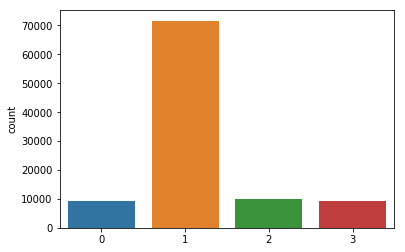

In [41]:
import seaborn as sns
sns.countplot(gMixture_Global.alpha_init.reshape(10000*10,M_seted).argmax(axis=1))

In [43]:
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

*** Ours Global multiples runs***
Train
A result
 ====  ======  ==========  ============  ===========  ============
  ..            Accuracy    F1 (micro)    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ===========  ============
   0  Global      0.9665        0.9665    0.0279167     0.0279167
====  ======  ==========  ============  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.941983              0.214625                   0.941983               0.214625
====  ========================  ====================  =========================  =====================
Test


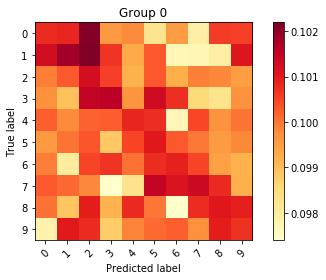

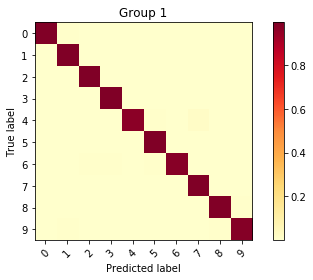

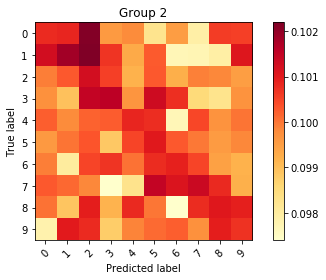

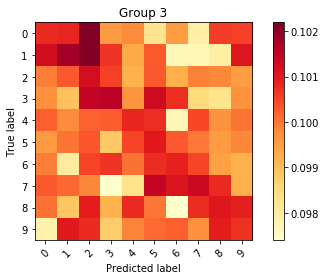

Inertia: 0.3570498118598191
A result
 ====  ========  ===========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups         Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ===========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  6.58206e-05       0  2.30253       0.101135   2.29128      -0.0911213  0.00126166       0.326         0.326
   1         1  0.999802         59  0.0889964     0.987102   0.013002      0.990646   0.985669         0.701         0.701
   2         2  6.58718e-05       0  2.30253       0.101137   2.29127      -0.0911183  0.00126299       0.326         0.326
   3         3  6.58088e-05       0  2.30253       0.101135   2.29129      -0.0911219  0.00126136       0.326         0.326
====  ========  ===========  ======  =========  ===========  =========  =============  =======

In [44]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
#results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

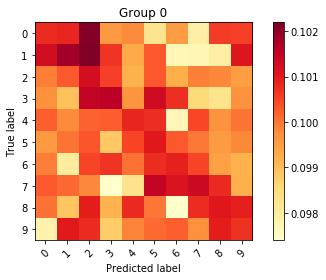

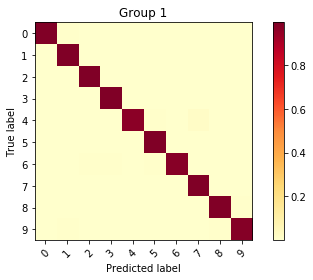

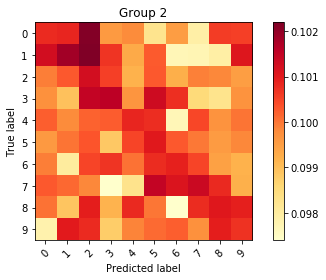

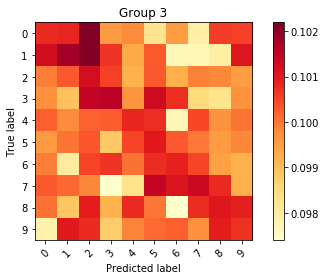

Inertia: 0.3570498118598191
A result
 ====  ========  ===========  ======  =========  ===========  =========  =============  ==========
  ..    Groups         Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer
====  ========  ===========  ======  =========  ===========  =========  =============  ==========
   0         0  6.58206e-05       0  2.30253       0.101135   2.29128      -0.0911213  0.00126166
   1         1  0.999802         59  0.0889964     0.987102   0.013002      0.990646   0.985669
   2         2  6.58718e-05       0  2.30253       0.101137   2.29127      -0.0911183  0.00126299
   3         3  6.58088e-05       0  2.30253       0.101135   2.29129      -0.0911219  0.00126136
====  ========  ===========  ======  =========  ===========  =========  =============  ==========


In [45]:
results = evaluate.calculate_metrics(conf_pred=c_M)